# Compute files for cloud plots for models

In [1]:
%load_ext autoreload
%autoreload 2


import useful_scit.util.log as log
import numpy as np
from bs_fdbck_clean.util.BSOA_datamanip import broadcast_vars_in_ds_sel, rn_dic_ec_earth_cloud
from datetime import timedelta

In [2]:

import xarray as xr

import matplotlib.pyplot as plt
from bs_fdbck_clean.constants import path_extract_latlon_outdata

from bs_fdbck_clean.util.imports import import_fields_xr_echam

from bs_fdbck_clean.util.BSOA_datamanip import compute_total_tau, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud, \
    rn_dic_noresm_cloud

from bs_fdbck_clean.util.BSOA_datamanip import fix_echam_time

import pandas as pd

from timeit import default_timer as timer

from dask.diagnostics import ProgressBar

from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/bs_fdbck_clean/data_info


In [3]:
from bs_fdbck_clean.constants import path_measurement_data

In [4]:
xr.set_options(keep_attrs=True)
log.ger.setLevel(log.log.INFO)

## General settings

In [5]:

select_station = 'SMR'

calc_seasons = ['ALL_year']

tau_lims = [5, 50]
r_eff_lim = 1
cloud_top_temp_above = -15
cld_water_path_above = 50

postproc_data = path_measurement_data / 'model_station' / select_station
postproc_data_obs = path_measurement_data / select_station / 'processed'

In [6]:
lon_lims = [22.,30.]
lat_lims = [60.,66.]

lat_station = 61.85
lon_station = 24.28
model_lev_i=-1

temperature = 273.15  # K

from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 = '2015-01-01'
to_time2 = '2019-01-01'
sel_years_from_files = ['2012', '2014', '2015', '2018']

In [7]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f' % (*lon_lims,)
str_latlim = '%.1f-%.1f' % (*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'

#### Daytime values


Set the daytime to be from 10 to 17 each day

In [8]:
daytime_from = 9
daytime_to = daytime_from + 7

## Read in model station data:

In [9]:
models = ['UKESM','ECHAM-SALSA', 'NorESM', 'EC-Earth']
mod2cases = {'ECHAM-SALSA': ['SALSA_BSOA_feedback'],
             'NorESM': ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth': ['ECE3_output_Sara'],
             }
mod2cases = {'ECHAM-SALSA': ['SALSA_BSOA_feedback'],
             'NorESM': ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth': ['ECE3_output_Sara'],
             'UKESM':['AEROCOMTRAJ'],
             }
di_mod2cases = mod2cases.copy()

In [10]:
dic_df_station = dict()
for mod in models:
    print(mod)
    dic_df_station[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data / f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_station[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_station[mod][ca].index = pd.to_datetime(dic_df_station[mod][ca].index)
        # dic_df_mod_case[mod][ca].to_csv(fn_out)

UKESM
UKESM AEROCOMTRAJ
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_UKESM_AEROCOMTRAJ.csv
ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_EC-Earth_ECE3_output_Sara.csv


## Calculate datasets for each model

# NorESM

In [11]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

case_name1 = 'OsloAero_intBVOC_f09_f09_mg17_full'
case_name2 = 'OsloAero_intBVOC_f09_f09_mg17_ssp245'

In [12]:
cases = [case_name]

#### Path input data

In [13]:
path_input_data_noresm = path_extract_latlon_outdata / case_name

#### Filenames to store products in 3d/2d

In [14]:
# Filename for case1 concatinated over time
fn1 = path_extract_latlon_outdata / case_name1 / f'{case_name1}.h1._{from_time1}-{to_time1}_concat_subs_{str_coordlims}.nc'

# Select variables and time:
fn1_2 = fn1.parent / f'{fn1.stem}_sort.nc'
# Sortby time:
fn1_3 = fn1.parent / f'{fn1.stem}_sort3.nc'

# Filename for case1 concatinated over time

fn2 = path_extract_latlon_outdata / case_name2 / f'{case_name2}.h1._{from_time2}-{to_time2}_concat_subs_{str_coordlims}.nc'

# Select variables and time:
fn2_2 = fn2.parent / f'{fn2.stem}_sort.nc'
# Sortby time:
fn2_3 = fn2.parent / f'{fn2.stem}_sort3.nc'

# Concatinated case1 and case2
fn_comb = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
# Concatinated only

# fn_comb_lev1           = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1.nc'
fn_comb_lev1_final = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_comb_lev1_finaler = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finaler.nc'
fn_comb_lev1_final_csv = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final_wet_season.csv'
fn_final_csv_stem = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.csv'

In [15]:
print(fn_comb_lev1_final_csv)

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final_wet_season.csv


#### Define NorESM station variables and cloud variables

In [16]:
varl_st = ['SOA_NA', 'SOA_A1', 'OM_NI', 'OM_AI', 'OM_AC', 'SO4_NA', 'SO4_A1', 'SO4_A2', 'SO4_AC', 'SO4_PR',
           'BC_N', 'BC_AX', 'BC_NI', 'BC_A', 'BC_AI', 'BC_AC', 'SS_A1', 'SS_A2', 'SS_A3', 'DST_A2', 'DST_A3',
           'N50', 'N100', 'N150', 'N200', 'N500',
           #           'N50-500','N100-500', 'N150-500', 'N200-500',
           # 'OA',
           ]
varl_st_computed= ['OA', 'T_C', 'OA_STP','OA_amb',
           'N50_STP', 'N100_STP', 'N150_STP', 'N200_STP', 'N500_STP',
                  
                  ]

varl_cl = ['TOT_CLD_VISTAU', 'TOT_ICLD_VISTAU', 'TGCLDCWP', 'TGCLDLWP', 'TGCLDIWP',
           'TOT_CLD_VISTAU_s', 'TOT_ICLD_VISTAU_s', 'optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL', 'ACTNL', 'TGCLDLWP',
           'FSDSC', 'FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC', 'FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

#### Concatinate files, compute 2D fields from 3D fields (compute tau) and sortby time.

In [17]:
if not fn_comb.exists():
    if (not fn1_2.exists()) or (not fn2_2.exists()):
        ds_mod1 = xr.open_dataset(fn1, chunks={'time': 96}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod2 = xr.open_dataset(fn2, chunks={'time': 96}, engine='netcdf4')

        varl1 = set(ds_mod1.data_vars)

        varl2 = set(ds_mod2.data_vars)

        varl = list(varl1.intersection(varl2))

        ds_mod1 = ds_mod1[varl].sel(time=slice(sel_years_from_files[0], sel_years_from_files[1]))  # .sortby('time')

        ds_mod2 = ds_mod2[varl].sel(time=slice(sel_years_from_files[2], sel_years_from_files[3]))  # .sortby('time')
        if not fn1_2.exists():
            delayed_obj = ds_mod1.to_netcdf(fn1_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
        if not fn2_2.exists():
            delayed_obj = ds_mod2.to_netcdf(fn2_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()

    if not fn1_3.exists():
        ds_mod1 = xr.open_dataset(fn1_2, chunks={'time': 48}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod1 = compute_total_tau(ds_mod1)
        ds_mod1 = ds_mod1.isel(lev=model_lev_i)
        ds_mod1 = ds_mod1.sortby('time')  # .sel(time=slice('2012','2014'))
        delayed_obj = ds_mod1.to_netcdf(fn1_3, compute=False)
        print('hey 1')
        with ProgressBar():
            results = delayed_obj.compute()
    if not fn2_3.exists():
        ds_mod2 = xr.open_dataset(fn2_2, chunks={'time': 48}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod2 = compute_total_tau(ds_mod2)
        ds_mod2 = ds_mod2.isel(lev=model_lev_i)
        ds_mod2 = ds_mod2.sortby('time')  # .sel(time=slice('2012','2014'))
        delayed_obj = ds_mod2.to_netcdf(fn2_3, compute=False)
        print('hey')
        with ProgressBar():
            results = delayed_obj.compute()

    ds_mod = xr.open_mfdataset([fn1_3, fn2_3], combine='by_coords', concat_dim='time')

    fn_comb.parent.mkdir(exist_ok=True, )

    delayed_obj = ds_mod.to_netcdf(fn_comb, compute=False)
    with ProgressBar():
        results = delayed_obj.compute()

    # ds_mod = xr.concat([ds_mod1[varl].sel(time=slice('2012','2014')), ds_mod2[varl].sel(time=slice('2015','2018'))], dim='time')

##### Check:

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


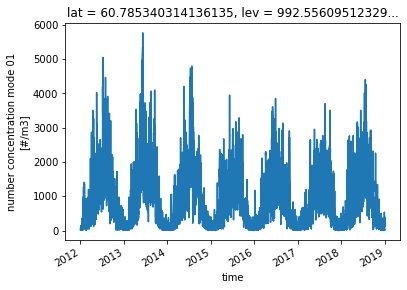

In [18]:
ds_mod = xr.open_dataset(fn_comb, engine='netcdf4', chunks={'time': 48})
(1e-6 * ds_mod['NCONC01'].isel(lat=0, lon=0)).plot()

#### Change units and compute variables

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [19]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb, engine='netcdf4').isel(ilev=model_lev_i)
    # ds_sel = ds_all.sel(lat = lat_station, lon= lon_station, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
        nbnd=0
    ).squeeze()
    # ds_all = broadcase_station_data(ds_all, lon = lon_station, lat = lat_station)
    ds_all = change_units_and_compute_vars(ds_all, temperature = temperature)

    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()


#### Add variables from station data to imitate using station measurements

In [20]:
df_comb_station = dic_df_station['NorESM']['OsloAero_intBVOC_f09_f09_mg17_fssp']
df_comb_station.head()

,station,ACTREL,lev,BC_A,BC_AC,BC_AI,BC_AX,BC_N,BC_NI,COAGNUCL,...,hour,is_JJA,is_JA,isSummer,year,density,ambient2stp_correction_factor,N100_STP,N200_STP,N50_STP
time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 01:00:00,SMR,0.0,992.556095,7.165361e-11,2.874122e-12,1.062304e-11,2.001164e-11,1.403718e-10,1.900030e-16,0.000004,...,0,False,False,False,2012,1.290830,1.001098,NaN,NaN,NaN
2012-01-02 02:00:00,SMR,0.0,992.556095,6.776110e-11,3.136896e-12,1.015449e-11,2.030955e-11,1.432439e-10,2.271426e-16,0.000004,...,1,False,False,False,2012,1.289752,1.001935,NaN,NaN,NaN
2012-01-02 03:00:00,SMR,0.0,992.556095,6.566561e-11,3.785762e-12,1.001973e-11,2.074075e-11,1.463301e-10,2.643147e-16,0.000004,...,2,False,False,False,2012,1.288403,1.002984,NaN,NaN,NaN
2012-01-02 04:00:00,SMR,0.0,992.556095,6.431399e-11,6.004582e-12,1.001325e-11,2.124108e-11,1.503158e-10,3.295160e-16,0.000004,...,3,False,False,False,2012,1.286599,1.004390,NaN,NaN,NaN
2012-01-02 05:00:00,SMR,0.0,992.556095,6.334269e-11,8.331037e-12,9.825345e-12,2.174707e-11,1.512403e-10,3.650696e-16,0.000004,...,4,False,False,False,2012,1.283672,1.006681,NaN,NaN,NaN


In [21]:
from bs_fdbck_clean.util.BSOA_datamanip import broadcast_vars_in_ds_sel

#### Open dataset computed above

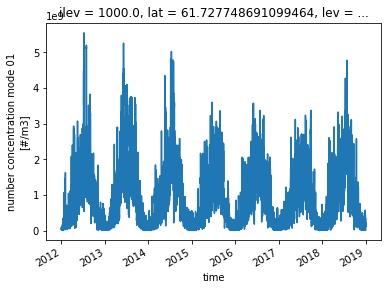

In [22]:

ds_all = xr.open_dataset(fn_comb_lev1_final, chunks={'lon': 1}, engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['NCONC01'].isel(lat=1, lon=1).plot()

#### NorESM Shift time step to start of period to be consistent with measurements and other models

In [23]:
#ind = df.index
#df.index = ind - datetime.timedelta(hours=1)
if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=1)
    ds_all['time'].attrs['timezone'] = 'utc'
    #ds_all['time'].attrs['timezone'] = 'utc+2'
    print('shifted time by -1 for NorESM')

shifted time by -1 for NorESM


#### Shift timezone

In [24]:

with ProgressBar():
    ds_all.load()

if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index + timedelta(hours=2)
    ds_all['time'].attrs['timezone'] = 'utc+2'
    print('shifted time by -2')
    # dic_ds[k] = _ds

[########################################] | 100% Completed | 32.8s
shifted time by -2


#### *Mask if ice water path more than 5% of total water path

In [25]:
mask_liq_cloudtop = (ds_all['FCTL']>0.05) & (ds_all['FCTL']/(ds_all['FCTL']+ds_all['FCTI'])>.8)

mask_liq_cloudtop
ds_all['mask_liq_cloudtop'] = mask_liq_cloudtop
#ds_all = ds_all.where(mask_liq_cloudtop)

In [26]:
ds_all['frac_lwp2cwp'] = ds_all['TGCLDLWP']/(ds_all['TGCLDIWP']+ds_all['TGCLDLWP'])
ds_all['mask_by_lwp2cwp'] = ds_all['frac_lwp2cwp']>0.95

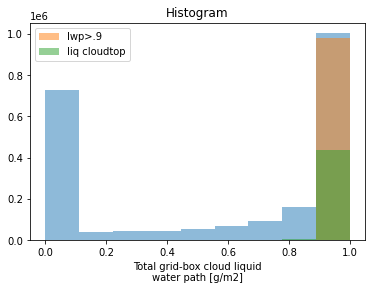

In [27]:
ds_all['frac_lwp2cwp'].plot.hist(alpha=0.5,bins=np.linspace(0,1,10))

ds_all['frac_lwp2cwp'].where(ds_all['frac_lwp2cwp']>0.9).plot.hist(alpha=0.5, bins=np.linspace(0,1,10),label='lwp>.9')
ds_all['frac_lwp2cwp'].where(ds_all['mask_liq_cloudtop']).plot.hist(alpha=0.5, bins=np.linspace(0,1,10), label='liq cloudtop')
plt.legend()

(array([416416.,  34345.,  32935.,  35771.,  61788.,  34269.,  22360.,
         25598.,  29744., 147947.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

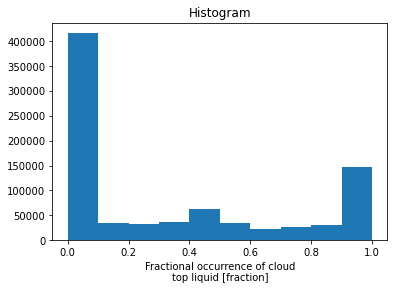

In [28]:
ds_all['FCTL'].where(ds_all['mask_by_lwp2cwp']).plot.hist()

In [29]:
ds_all= ds_all.where(ds_all['mask_by_lwp2cwp'])

#### * Mask if cloud top fraction of liquid is below 10 %

(array([21557., 22335., 22439., 42711., 34084., 12931., 16717., 18571.,
        22760., 99046.]),
 array([0.10001411, 0.19001271, 0.2800113 , 0.37000987, 0.46000847,
        0.55000705, 0.64000565, 0.73000425, 0.8200028 , 0.9100014 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

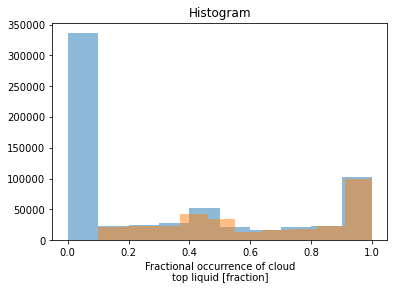

In [30]:
ds_all['FCTL'].where(ds_all['TGCLDCWP_incld']>50).plot(alpha=.5)
ds_all.where(ds_all['FCTL']>.1)['FCTL'].where(ds_all['TGCLDCWP_incld']>50).plot(alpha=.5)

In [31]:
ds_all = ds_all.where(ds_all['FCTL']>.1)

#### Broadcast computed variables so that only station value is in the gridcells.

In [32]:
ds_smll = ds_all[['NCONC01']]

In [33]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

In [34]:
ds_all

<xarray.Dataset>
Dimensions:                 (time: 61344, lat: 6, lon: 7)
Coordinates:
    ilev                    float64 1e+03
  * lat                     (lat) float64 60.79 61.73 62.67 63.61 64.55 65.5
    lev                     float64 992.6
  * lon                     (lon) float64 22.5 23.75 25.0 26.25 27.5 28.75 30.0
  * time                    (time) datetime64[ns] 2012-01-02T01:00:00 ... 201...
Data variables: (12/197)
    NMR13                   (time, lat, lon) float32 nan nan nan ... nan nan nan
    nscur                   (time, lat, lon) float64 nan nan nan ... nan nan nan
    hybm                    (time, lat, lon) float64 nan nan nan ... nan nan nan
    T                       (time, lat, lon) float32 nan nan nan ... nan nan nan
    EC550AER                (time, lat, lon) float32 nan nan nan ... nan nan nan
    FLNS                    (time, lat, lon) float32 nan nan nan ... nan nan nan
    ...                      ...
    TOT_CLD_VISTAU_s_incld  (time, lat, lon) float32 nan nan nan ... nan nan nan
    optical_depth           (time, lat, lon) float32 nan nan nan ... nan nan nan
    transmittance           (time, lat, lon) float32 nan nan nan ... nan nan nan
    mask_liq_cloudtop       (time, lat, lon) float64 nan nan nan ... nan nan nan
    frac_lwp2cwp            (time, lat, lon) float32 nan nan nan ... nan nan nan
    mask_by_lwp2cwp         (time, lat, lon) float64 nan nan nan ... nan nan nan
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              OsloAero_intBVOC_f09_f09_mg17_full
    logname:           x_sarbl
    host:              
    initial_file:      spinup_freemet_f09_f09_mg17_from2000.cam.i.2011-01-01-...
    topography_file:   /proj/cesm_input-data/inputdata/noresm-only/inputForNu...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1
    history:           Mon Apr 11 21:44:12 2022: ncrcat /proj/bolinc/users/x_...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


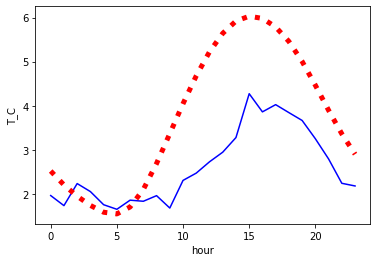

In [35]:
#ds_all['T_C'].resample(time='hour').mean().plot()
ds_all['T_C'].sel(lat=lat_station, lon=lon_station, method='nearest').groupby(ds_all['time.hour']).mean().plot(c='b')
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot(linestyle=':', c='r', linewidth=5)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


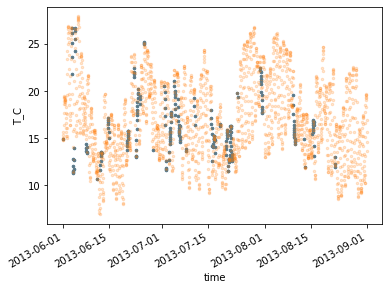

In [36]:

ds_all['T_C'].sel(time=slice('2013-06','2013-08')).sel(lat=lat_station, lon=lon_station, method='nearest').plot(label='full dataset',linewidth=0, marker='.', markersize=5)
ds_comb_station['T_C'].sel(time=slice('2013-06','2013-08')).plot(label='station dataset',linewidth=0,  marker='.', markersize=5, alpha=.2)

In [37]:
varl_tmp = varl_st + varl_st_computed

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [38]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

BC_NI
replacing BC_NI 
SS_A3
replacing SS_A3 
DST_A3
replacing DST_A3 
SO4_NA
replacing SO4_NA 
BC_AC
replacing BC_AC 
N50_STP
replacing N50_STP 
OM_AC
replacing OM_AC 
SO4_PR
replacing SO4_PR 
SS_A2
replacing SS_A2 
N500
replacing N500 
N150
replacing N150 
SO4_A2
replacing SO4_A2 
OM_NI
replacing OM_NI 
N200_STP
replacing N200_STP 
SOA_A1
replacing SOA_A1 
BC_AX
replacing BC_AX 
N100_STP
replacing N100_STP 
SO4_AC
replacing SO4_AC 
OA_STP
replacing OA_STP 
SS_A1
replacing SS_A1 
DST_A2
replacing DST_A2 
BC_N
replacing BC_N 
T_C
replacing T_C 
OM_AI
replacing OM_AI 
BC_A
replacing BC_A 
BC_AI
replacing BC_AI 
SOA_NA
replacing SOA_NA 
SO4_A1
replacing SO4_A1 


#### Replace all values by station values

In [39]:
for v in varl_tmp:
    if v not in ds_smll:
        print(f'skipping {v} because not in dataset')
        continue
    ds_all[v] = ds_smll[v]
    print(v)

BC_NI
SS_A3
DST_A3
SO4_NA
BC_AC
N50_STP
OM_AC
SO4_PR
SS_A2
N500
N150
SO4_A2
OM_NI
N200_STP
SOA_A1
BC_AX
N100_STP
SO4_AC
OA_STP
SS_A1
DST_A2
BC_N
T_C
OM_AI
BC_A
BC_AI
SOA_NA
SO4_A1


##### Controle plots

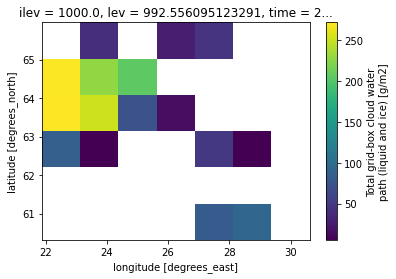

In [40]:
ds_all['TGCLDCWP_incld'].sel(time='2012-05-30 02:00:00').plot()

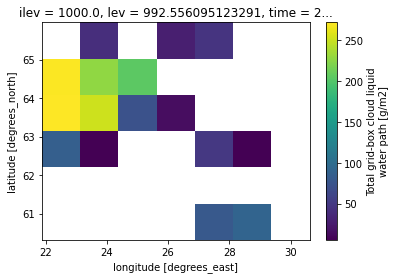

In [41]:
ds_all['TGCLDLWP_incld'].sel(time='2012-05-30 02:00:00').plot()

#### Finally steps

In [42]:
dic_ds = dict()
dic_ds[case_name_noresm] = ds_all

##### Rename vars

In [43]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_noresm_cloud)

#### Save netcdf file

In [44]:
if not fn_comb_lev1_finaler.exists():
    with ProgressBar():
        dic_ds[case_name_noresm].to_netcdf(fn_comb_lev1_finaler)

#### Controle plots

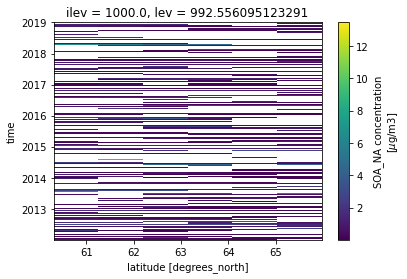

In [45]:
dic_ds[case_name_noresm]['OA'].mean('lon').plot()

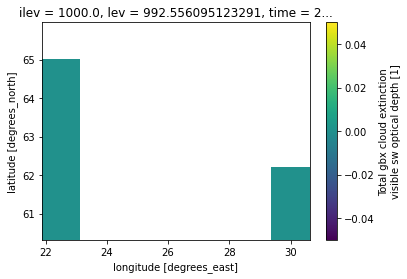

In [46]:
dic_ds[case_name_noresm]['COT'].sel(time='2018-01-07 00:00:00').plot()

(0.0, 400.0)

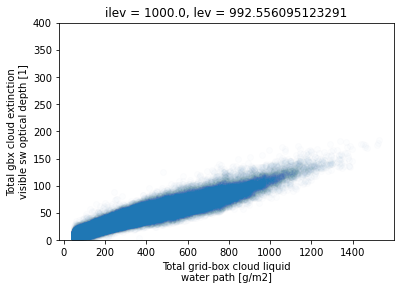

In [47]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']

_ds.where(_ds['COT'] > 0).where(_ds['CWP'] > 50).plot.scatter(x='CWP', y='COT', alpha=0.01)
plt.ylim([0, 400])

(0.0, 400.0)

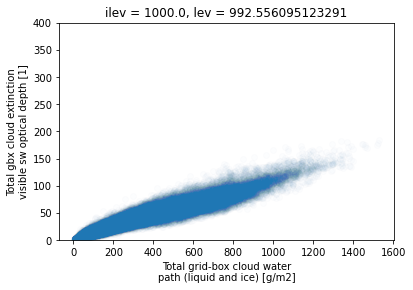

In [48]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']

_ds.where(_ds['COT'] > 0).where(_ds['CWP'] > 50).plot.scatter(x='TGCLDCWP', y='TOT_CLD_VISTAU_s', alpha=0.01)
plt.ylim([0, 400])

#### Save final csv

In [49]:
ds_noresm = ds_all.copy()

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_finalALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 5<COT<50!
Masking with 50<CWP and 800>CWP!
Masking with r_eff>1!
cloud and resampled
cloud_avg median
station


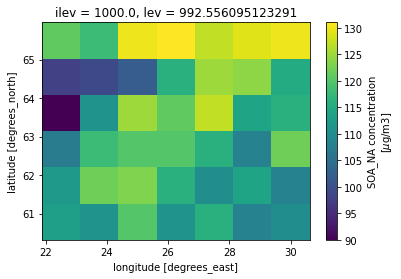

merge
df1
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_finalALL_year.csv
156.81630736403167
DONE! That took 156.81630736403167 seconds
That is  2.613605122733861 minuts


In [50]:
for seas in calc_seasons:
    _fn_csv = fn_final_csv_stem.parent / (fn_final_csv_stem.stem + seas + '.csv')
    print(_fn_csv)
    if True:#not _fn_csv.exists():
        start = timer()

        dic_df = get_dic_df_mod(
            dic_ds,
            select_hours_clouds=True,
            summer_months=season2month[seas],
            from_hour=daytime_from,
            # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50]),
            kwrgs_mask_clouds=dict(min_reff=r_eff_lim, min_cwp=cld_water_path_above, tau_bounds=tau_lims),

            # kwrgs_mask_clouds = dict(min_reff = 1),
            to_hour=daytime_to,
        )

        df_mod = dic_df[case_name_noresm]

        # df_mod= df_mod.dropna()
        print(_fn_csv)
        df_mod.to_csv(_fn_csv)
        end = timer()
        print(end - start)  # Time in seconds, e.g. 5.38091952400282
        print(f'DONE! That took {(end - start)} seconds')
        print(f'That is  {((end - start) / 60)} minuts')

In [51]:
df_mod.to_xarray()

<xarray.Dataset>
Dimensions:            (time: 2557, lat: 6, lon: 7, station: 1)
Coordinates:
  * time               (time) datetime64[ns] 2012-01-02 ... 2019-01-01
  * lat                (lat) float64 60.79 61.73 62.67 63.61 64.55 65.5
  * lon                (lon) float64 22.5 23.75 25.0 26.25 27.5 28.75 30.0
  * station            (station) object 'SMR'
Data variables: (12/98)
    FLNSC              (time, lat, lon, station) float32 nan nan nan ... nan nan
    ACTNL              (time, lat, lon, station) float32 nan nan nan ... nan nan
    r_eff              (time, lat, lon, station) float32 nan nan nan ... nan nan
    FSNSC              (time, lat, lon, station) float32 nan nan nan ... nan nan
    FSDSCDRF           (time, lat, lon, station) float32 nan nan nan ... nan nan
    CLDTOT             (time, lat, lon, station) float32 nan nan nan ... nan nan
    ...                 ...
    BC_A               (time, lat, lon, station) float64 4.478e-11 ... nan
    BC_AI              (time, lat, lon, station) float64 6.496e-12 ... nan
    SOA_NA             (time, lat, lon, station) float64 0.0007001 ... nan
    DOD500             (time, lat, lon, station) float32 nan nan nan ... nan nan
    SO4_A1             (time, lat, lon, station) float64 0.0124 0.0124 ... nan
    year               (time, lat, lon, station) int64 2012 2012 ... 2019 2019

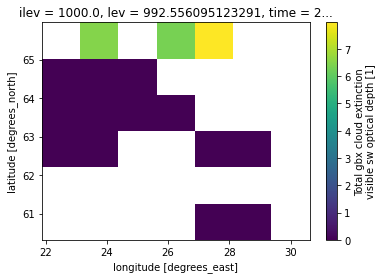

In [52]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time='2012-05-30 02:00:00').plot()

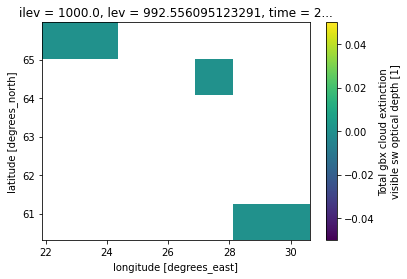

In [53]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time='2012-05-30 23:00:00').plot()

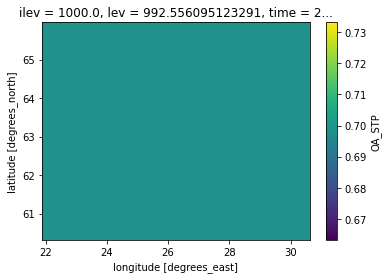

In [54]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['OA_STP'].sel(time='2012-05-30 02:00:00').plot()

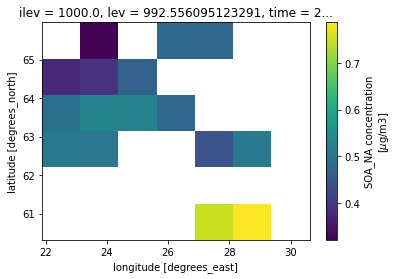

In [55]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['OA'].sel(time='2012-05-30 02:00:00').plot()

# ECHAM-SALSA

#### Names etc

In [56]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res = 'locations'
model_name = 'ECHAM-SALSA'
model_name_echam = 'ECHAM-SALSA'

#### Input path

In [57]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam

In [58]:

cases_echam = [case_name_echam]

#### Station variables  and others

In [59]:
varl_st_echam = [
    'mmrtrN500',
    'mmrtrN250',
    'mmrtrN200',
    'mmrtrN100',
    'mmrtrN50',
    'mmrtrN3',
    'SO2_gas',
    'APIN_gas',
    'TBETAOCI_gas',
    'BPIN_gas',
    'LIMON_gas',
    'SABIN_gas',
    'MYRC_gas',
    'CARENE3_gas',
    'ISOP_gas',
    'VBS0_gas',
    'V*BS1_gas',
    'VBS10_gas',
    'ORG_mass',
    'oh_con',
    'tempair',
    'ccn02',
    'ccn10',
]

varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    # 'ceff_ct_incl',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
    'tempair',
    'tempair_ct',
    'T_ct',

]



#### Filenames:

In [60]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_wet_season.csv'
fn_final_echam_csv_stem = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

#### Open data area around station

In [61]:
fl_open = []

for v in varl_cl_echam + varl_st_echam:
    fn = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    # print(fn)
    if fn.exists():
        fl_open.append(fn)
    else:
        print(f'{v} not found')

tempair_ct not found
T_ct not found
mmrtrN500 not found
mmrtrN250 not found
mmrtrN3 not found
SO2_gas not found
APIN_gas not found
TBETAOCI_gas not found
BPIN_gas not found
LIMON_gas not found
SABIN_gas not found
MYRC_gas not found
CARENE3_gas not found
ISOP_gas not found
VBS0_gas not found
V*BS1_gas not found
VBS10_gas not found
oh_con not found


#### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [62]:
fl_open = list(set(fl_open))

In [63]:
ds_all = xr.open_mfdataset(fl_open, decode_cf=False)

In [64]:
fn_final_echam

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0.nc')

In [65]:
if not fn_final_echam.exists():
    ds_all = xr.open_mfdataset(fl_open, decode_cf=False)
    # ds_iso = xr.open_dataset(fl_open[21])
    # ds = xr.merge([ds_iso,ds])
    ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)

    # ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_echam(ds_all)

    # ds_sel = ds_all.sel(lat = lat_station, lon= lon_station, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    ds_all = ds_all.drop(['hyai', 'hybi', 'hyam', 'hybm']).squeeze()
    ds_all = ds_all.isel(lev=model_lev_i)

    # ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam, lon = lon_station, lat = lat_station)

    ds_all = change_units_and_compute_vars_echam(ds_all)

    delayed_obj = ds_all.to_netcdf(fn_final_echam, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

#### Use station data computed before:

In [66]:
df_comb_station = dic_df_station['ECHAM-SALSA']['SALSA_BSOA_feedback']

#### Compute Nx-500

In [67]:

for v in ['N50', 'N100', 'N200', 'N150', 'N25', 'N70', 'N250']:
    if v in df_comb_station.columns:
        df_comb_station[v + '-500'] = df_comb_station[v] - df_comb_station['N500']
        varl_st_computed.append(v + '-500')
        print(v)

N50
N100
N200
N250


In [68]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

In [69]:
fn_final_echam

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0.nc')

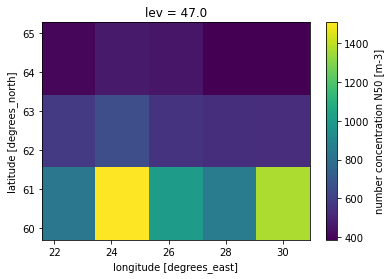

In [70]:
ds_all = xr.open_dataset(fn_final_echam, engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['N50'].mean('time').plot()  # .isel(lat=0, time=0).plot()#.shape#.plot()

In [71]:
ds_all['time'].attrs['timezone'] = 'utc'

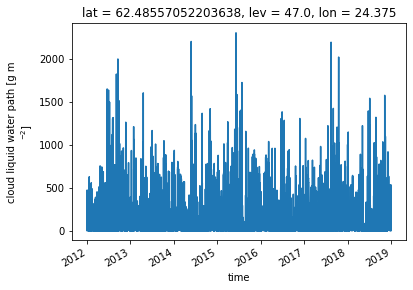

In [72]:
ds_all['cwp_incld'].isel(lat=1, lon=1).plot()

#### Fix time for echam

In [73]:
with xr.set_options(keep_attrs=True):
    attrs = ds_all['time'].attrs.copy()
    ds_all['time'] = ds_all['time'].to_dataframe()['time'].apply(fix_echam_time).values
    ds_all['time'].attrs = attrs

#### Finally produce daily median dataset:

In [74]:
dic_ds = dict()
dic_ds[case_name] = ds_all

##### Controle plots

(array([291693., 106384.,  71099.,  54194.,  42760.,  33175.,  26867.,
         20957.,  16831.,  13456.,  10544.,   8321.,   6357.,   5171.,
          4026.,   3148.,   2599.,   2009.,   1675.]),
 array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
         210.52631579,  263.15789474,  315.78947368,  368.42105263,
         421.05263158,  473.68421053,  526.31578947,  578.94736842,
         631.57894737,  684.21052632,  736.84210526,  789.47368421,
         842.10526316,  894.73684211,  947.36842105, 1000.        ]),
 <BarContainer object of 19 artists>)

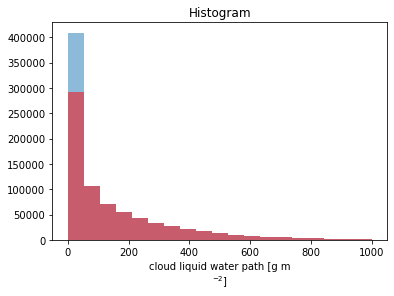

In [75]:
ds_all['cwp'].plot(bins=np.linspace(0, 1000, 20), alpha=.5, )

ds_all['cwp_incld'].plot(bins=np.linspace(0, 1000, 20), alpha=.5, color='r')

In [76]:
ds_all['cwp_incld2'] = ds_all['cwp'] / ds_all['cl_clfr_max']

In [77]:
ds_all['cod_incld2'] = ds_all['cod'] / ds_all['cl_clfr_max']

(array([ 1831.,  1899.,  2143.,  2375.,  2500.,  2672.,  2950.,  3308.,
         3631.,  3817.,  4159.,  4686.,  4921.,  5441.,  6114.,  6627.,
         7639.,  8218.,  9485., 10449., 11700., 12652., 14244., 15431.,
        17147., 18642., 20131., 21287., 22738., 23516., 24500., 25355.,
        26646., 27686., 28492., 29666., 29939., 30008., 28837., 27743.,
        25611., 22807., 19978., 16341., 12386.,  9104.,  6349.,  4145.,
         2260.]),
 array([1.00000000e+00, 1.15681872e+00, 1.33822954e+00, 1.54808898e+00,
        1.79085830e+00, 2.07169840e+00, 2.39657948e+00, 2.77240800e+00,
        3.20717346e+00, 3.71011828e+00, 4.29193426e+00, 4.96498988e+00,
        5.74359321e+00, 6.64429612e+00, 7.68624610e+00, 8.89159334e+00,
        1.02859616e+01, 1.18989929e+01, 1.37649776e+01, 1.59235837e+01,
        1.84206997e+01, 2.13094102e+01, 2.46511245e+01, 2.85168821e+01,
        3.29888630e+01, 3.81621341e+01, 4.41466709e+01, 5.10696951e+01,
        5.90783791e+01, 6.83429746e+01, 7.9060

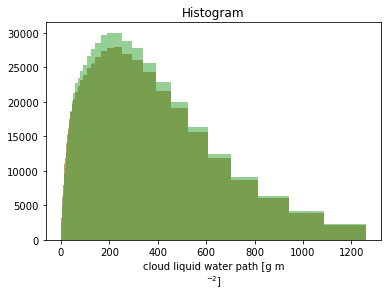

In [78]:
f, ax = plt.subplots(1)
ds_all['cwp'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)
ds_all['cwp_incld2'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)

(array([139697.,  37269.,  32513.,  29157.,  26683.,  24384.,  22319.,
         20450.,  18718.,  17138.,  16374.,  14876.,  14002.,  13551.,
         12668.,  12137.,  11594.,  10945.,  10669.,  10143.,   9864.,
          9324.,   9307.,   8707.,   8319.,   8012.,   7865.,   7513.,
          7192.,   6963.,   6813.,   6450.,   6169.,   5844.,   5586.,
          5516.,   5415.,   5143.,   4849.,   4707.,   4717.,   4468.,
          4225.,   4191.,   3943.,   3814.,   3711.,   3520.,   3340.]),
 array([  0.        ,   8.16326531,  16.32653061,  24.48979592,
         32.65306122,  40.81632653,  48.97959184,  57.14285714,
         65.30612245,  73.46938776,  81.63265306,  89.79591837,
         97.95918367, 106.12244898, 114.28571429, 122.44897959,
        130.6122449 , 138.7755102 , 146.93877551, 155.10204082,
        163.26530612, 171.42857143, 179.59183673, 187.75510204,
        195.91836735, 204.08163265, 212.24489796, 220.40816327,
        228.57142857, 236.73469388, 244.89795918, 253

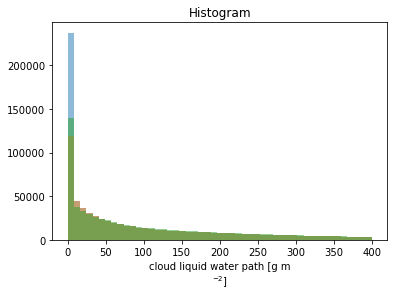

In [79]:
f, ax = plt.subplots(1)
ds_all['cwp'].plot.hist(bins=np.linspace(0, 400), alpha=.5, ax=ax)
ds_all['cwp_incld'].plot.hist(bins=np.linspace(0, 400), alpha=.5, ax=ax)
ds_all['cwp_incld2'].plot.hist(bins=np.linspace(0,400), alpha=.5, ax=ax)

(array([94755., 36607., 32019., 28654., 26164., 23345., 20854., 19177.,
        17547., 16473., 15743., 14750., 14044., 13213., 13018., 12234.,
        11286., 11087., 10682., 10145.,  9868.,  9521.,  8974.,  8856.,
         8530.,  8460.,  8034.,  7697.,  7378.,  7203.,  6979.,  6835.,
         6642.,  6356.,  6129.,  5752.,  5714.,  5646.,  5403.,  5132.,
         5019.,  4875.,  4728.,  4608.,  4432.,  4406.,  4193.,  4123.,
         3931.]),
 array([ 0.        ,  0.81632653,  1.63265306,  2.44897959,  3.26530612,
         4.08163265,  4.89795918,  5.71428571,  6.53061224,  7.34693878,
         8.16326531,  8.97959184,  9.79591837, 10.6122449 , 11.42857143,
        12.24489796, 13.06122449, 13.87755102, 14.69387755, 15.51020408,
        16.32653061, 17.14285714, 17.95918367, 18.7755102 , 19.59183673,
        20.40816327, 21.2244898 , 22.04081633, 22.85714286, 23.67346939,
        24.48979592, 25.30612245, 26.12244898, 26.93877551, 27.75510204,
        28.57142857, 29.3877551 , 30.20

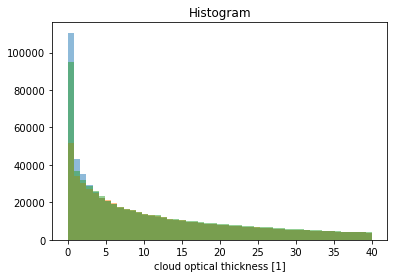

In [80]:
f, ax = plt.subplots(1)
ds_all['cod'].where(ds_all['cod']>0).plot.hist(bins=np.linspace(0, 40), alpha=.5, ax=ax)
ds_all['cod_incld'].where(ds_all['cod']>0).plot.hist(bins=np.linspace(0, 40), alpha=.5, ax=ax)
ds_all['cod_incld2'].where(ds_all['cod']>0).plot.hist(bins=np.linspace(0, 40), alpha=.5, ax=ax)

(0.0, 100.0)

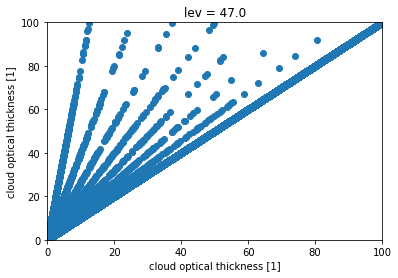

In [81]:
ds_all.where(ds_all['cod']>0).plot.scatter(x='cod',y='cod_incld',)
plt.xlim([0,100])
plt.ylim([0,100])

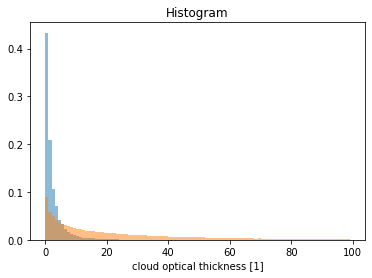

In [82]:
ds_all.where(ds_all['cl_clfr_max']<.4).where(ds_all['cod']>0.1)['cod'].plot.hist(bins=np.arange(100), alpha=.5, density=True)
ds_all.where(ds_all['cl_clfr_max']>.6).where(ds_all['cod']>0.1)['cod'].plot.hist(bins=np.arange(100), alpha=.5, density=True);

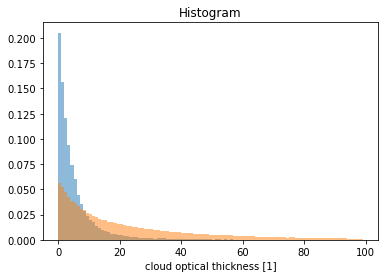

In [83]:
ds_all.where(ds_all['cl_time_max']<.8).where(ds_all['cod']>.1)['cod_incld'].plot.hist(bins=np.arange(100), alpha=.5, density=True)
ds_all.where(ds_all['cl_time_max']>.9).where(ds_all['cod']>.1)['cod_incld'].plot.hist(bins=np.arange(100), alpha=.5, density=True);

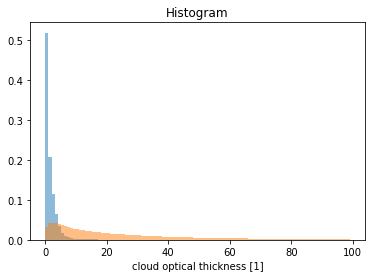

In [84]:
ds_all.where(ds_all['cl_time_max']<.8).where(ds_all['cod']>.1)['cod_incld2'].plot.hist(bins=np.arange(100), alpha=.5, density=True)
ds_all.where(ds_all['cl_time_max']>.9).where(ds_all['cod']>.1)['cod_incld2'].plot.hist(bins=np.arange(100), alpha=.5, density=True);

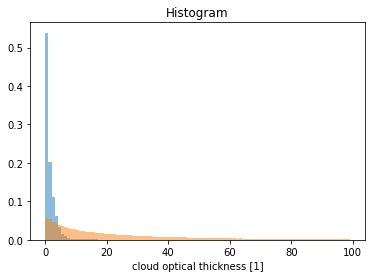

In [85]:
ds_all.where(ds_all['cl_time_max']<.8).where(ds_all['cod']>.1)['cod'].plot.hist(bins=np.arange(100), alpha=.5, density=True)
ds_all.where(ds_all['cl_time_max']>.9).where(ds_all['cod']>.1)['cod'].plot.hist(bins=np.arange(100), alpha=.5, density=True);

(array([67959., 33129., 29665., 26796., 24276., 23093., 21189., 19384.,
        18229., 16975., 15875., 15066., 14258., 13048., 12592., 12073.,
        11246., 10905., 10293.,  9988.,  9609.,  9033.,  8759.,  8394.,
         8111.,  7828.,  7585.,  7160.,  6887.,  6511.,  6528.,  6090.,
         5895.,  5713.,  5534.,  5353.,  5130.,  5018.,  4785.,  4623.,
         4397.,  4218.,  4268.,  3974.,  3894.,  3845.,  3723.,  3605.,
         3417.,  3230.,  3192.,  3195.,  3066.,  2824.,  2770.,  2771.,
         2761.,  2582.,  2539.,  2586.,  2308.,  2229.,  2070.,  2135.,
         2012.,  1990.,  1941.,  1818.,  1750.,  1811.,  1574.,  1575.,
         1584.,  1537.,  1391.,  1446.,  1446.,  1335.,  1303.,  1278.,
         1264.,  1220.,  1094.,  1095.,  1122.,  1073.,  1119.,  1032.,
         1019.,   910.,   951.,   827.,   830.,   847.,   773.,   725.,
          715.,   686.,   714.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21

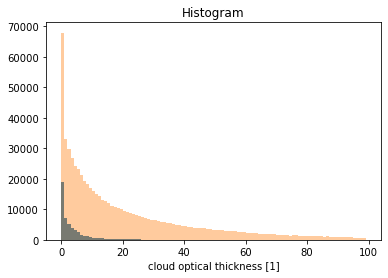

In [86]:
ds_all.where(ds_all['cod']<ds_all['cod_incld'])['cod_incld'].plot.hist(bins=np.arange(100))#x='cod',y='cod_incld',)
ds_all.where(ds_all['cod']>=ds_all['cod_incld'])['cod_incld'].plot.hist(bins=np.arange(100),alpha=0.4)#x='cod',y='cod_incld',)

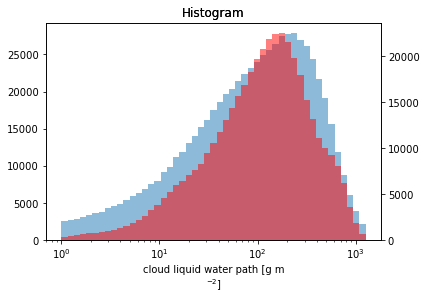

In [87]:
f, ax = plt.subplots(1)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)

ds_noresm['TGCLDCWP_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=0.5, ax=ax.twinx(), color='r')
plt.xscale('log')

#### *Mask values where cloud time max and cloud top cloud time is less than 10 percent 

(array([187235.,   9403.,   9172.,   9385.,      0.,  10307.,  10118.,
         11593.,  13975., 659332.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

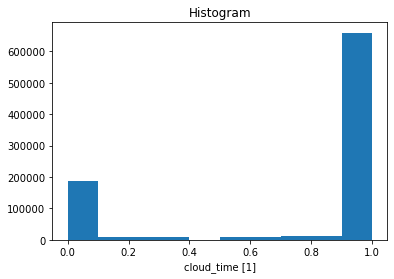

In [88]:
ds_all['cl_time_max'].plot.hist()

(array([  1319.,   2253.,   2611.,      0.,   2802.,   2914.,      0.,
          3498.,   3844., 109537.]),
 array([0.125 , 0.2125, 0.3   , 0.3875, 0.475 , 0.5625, 0.65  , 0.7375,
        0.825 , 0.9125, 1.    ], dtype=float32),
 <BarContainer object of 10 artists>)

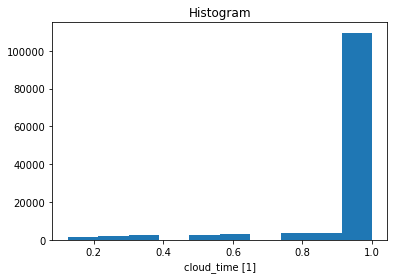

In [89]:
ds_all['cl_time_ct'].where(ds_all['cl_time_max']>.2).plot.hist()

In [90]:
number_before_mask = ds_all['ceff_ct_incld'].count()

In [91]:
ds_all = ds_all.where(ds_all['cl_time_max'] > .1)
ds_all = ds_all.where(ds_all['cl_time_ct'] > .1)

In [92]:
(ds_all['ceff_ct_incld'].count()-number_before_mask)/number_before_mask

<xarray.DataArray 'ceff_ct_incld' ()>
array(0.)
Coordinates:
    lev      float64 47.0
Attributes:
    long_name:    cloud droplet effective radius cloud top
    units:        um
    description:  cloud droplet effective radius cloud top

#### Shift timezone

In [93]:

with ProgressBar():
    ds_all.load()

if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index + timedelta(hours=2)
    ds_all['time'].attrs['timezone'] = 'utc+2'
    print('shifted time by +2')
    # dic_ds[k] = _ds

shifted time by +2


#### Broadcast computed variables so that only station value is in the gridcells.

In [94]:
ds_smll = ds_all[['mmrtrN100']]

In [95]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

##### Check time by comparing to station dataset

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


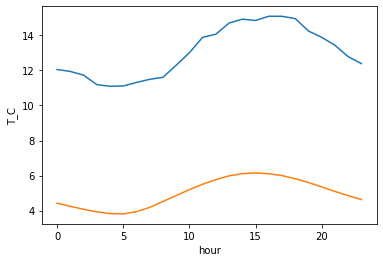

In [96]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_station, lon=lon_station, method='nearest').plot(label='full dataset')
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot(label='station dataset')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


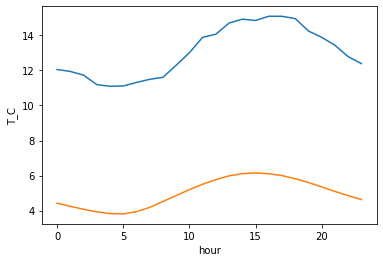

In [97]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_station, lon=lon_station, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


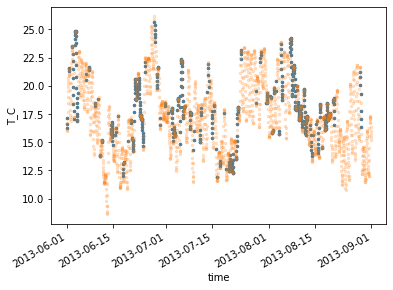

In [98]:

ds_all['T_C'].sel(time=slice('2013-06','2013-08')).sel(lat=lat_station, lon=lon_station, method='nearest').plot(label='full dataset',linewidth=0, marker='.', markersize=5)
ds_comb_station['T_C'].sel(time=slice('2013-06','2013-08')).plot(label='station dataset',linewidth=0,  marker='.', markersize=5, alpha=.2)

In [99]:
ds_comb_station = ds_comb_station.drop(['lon'])

In [100]:
varl_tmp = varl_st_echam + varl_st_computed

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [101]:
varl_tmp

['N200-500',
 'N50-500',
 'ISOP_gas',
 'SO2_gas',
 'OA',
 'mmrtrN100',
 'BPIN_gas',
 'mmrtrN50',
 'VBS0_gas',
 'CARENE3_gas',
 'APIN_gas',
 'LIMON_gas',
 'MYRC_gas',
 'ORG_mass',
 'ccn10',
 'TBETAOCI_gas',
 'VBS10_gas',
 'T_C',
 'SABIN_gas',
 'mmrtrN3',
 'N100-500',
 'mmrtrN200',
 'mmrtrN500',
 'oh_con',
 'ccn02',
 'N250-500',
 'mmrtrN250']

In [102]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

N200-500
replacing N200-500 
N50-500
replacing N50-500 
ISOP_gas
replacing ISOP_gas 
SO2_gas
replacing SO2_gas 
OA
replacing OA 
mmrtrN100
replacing mmrtrN100 
BPIN_gas
replacing BPIN_gas 
mmrtrN50
replacing mmrtrN50 
VBS0_gas
replacing VBS0_gas 
CARENE3_gas
replacing CARENE3_gas 
APIN_gas
replacing APIN_gas 
LIMON_gas
replacing LIMON_gas 
MYRC_gas
replacing MYRC_gas 
ORG_mass
replacing ORG_mass 
ccn10
replacing ccn10 
TBETAOCI_gas
replacing TBETAOCI_gas 
VBS10_gas
replacing VBS10_gas 
T_C
replacing T_C 
SABIN_gas
replacing SABIN_gas 
mmrtrN3
replacing mmrtrN3 
N100-500
replacing N100-500 
mmrtrN200
replacing mmrtrN200 
mmrtrN500
replacing mmrtrN500 
oh_con
replacing oh_con 
ccn02
replacing ccn02 
N250-500
replacing N250-500 
mmrtrN250
replacing mmrtrN250 


#### Replace all values by station values

In [103]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

(array([   0.,  783.,  590.,  841., 1379., 1818., 2142., 2247., 2236.,
        2298., 2196., 2249., 2084., 2045., 1855., 1808., 1873., 1643.,
        1654., 1490., 1477., 1401., 1322., 1328., 1274., 1162., 1201.,
        1138., 1039., 1043.,  965., 1040.,  950.,  877.,  879.,  823.,
         797.,  798.,  789.,  707.,  730.,  622.,  627.,  629.,  613.,
         568.,  598.,  539.,  508.,  465.]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <BarContainer object of 50 artists>)

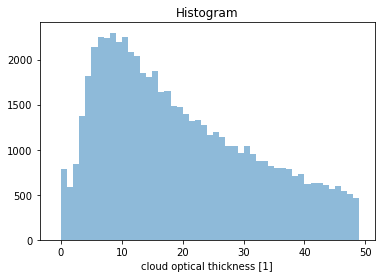

In [104]:
ds_all.where((ds_all['cwp_incld'] > 50) & (ds_all['cl_time_max'] > .1))['cod_incld'].plot.hist(bins=np.arange(-1, 50),
                                                                                               alpha=.5)

#### Final steps

In [105]:
dic_ds = dict()
dic_ds[case_name_echam] = ds_all

##### Rename vars

In [106]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_echam_cloud)

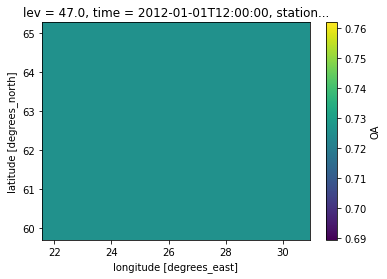

In [107]:
ds_all['OA'].isel(time=10).plot()

#### Save final csv

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 5<COT<50!
Masking with 50<CWP and 800>CWP!
Masking with r_eff>1!
Masking with temp>-15!
cloud and resampled
cloud_avg median
station


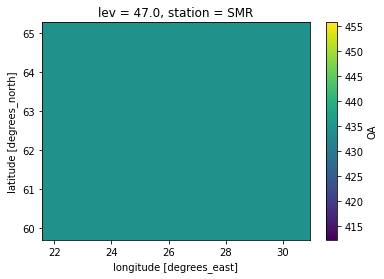

merge
df1


In [108]:
for seas in calc_seasons:
    _fn_csv = fn_final_echam_csv_stem.parent / (fn_final_echam_csv_stem.stem + seas + '.csv')
    print(_fn_csv)
    if True:  # not _fn_csv.exists():
        # for key in dic_ds.keys():

        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month[seas],
                                mask_cloud_values=True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds=dict(min_reff=r_eff_lim, min_cwp=cld_water_path_above,
                                                       tau_bounds=tau_lims),

                                )

        df_mod = dic_df[case_name_echam]
        # with ProgressBar():
        # df_mod = df_mod.dropna()
        df_mod.to_csv(_fn_csv)

<AxesSubplot:xlabel='CWP', ylabel='COT'>

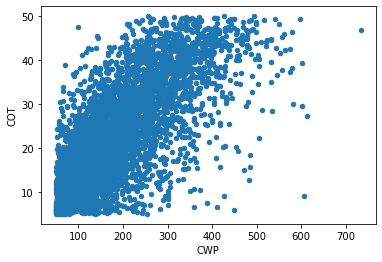

In [109]:
df_mod.plot.scatter(x='CWP', y='COT')

In [110]:
_fn_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv')

# EC-Earth

#### Names etc

In [111]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res = 'locations'
model_name = 'EC-Earth'
model_name_ec_earth = 'EC-Earth'

#### Input path:

In [112]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth / case_name_ec_earth

In [113]:

cases_ec_earth = [case_name_ec_earth]

#### Filenames:

In [114]:
fn_intermediate_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate.nc'
fn_intermediate_ec_earth_lev = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate_lev.nc'

fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'
fn_final_ec_earth_csv_stem = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}'

In [115]:
fn_final_ec_earth_csv_stem

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0')

#### Open pre calculated extracted fields

In [116]:
which = 'IFS'

In [117]:
fn_t = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'

In [118]:
fl_open = []
# ds_list =[]
dic_ds = dict()

for which in ['IFS', 'IFS_T']:
    fn = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
    print(fn)
    if fn.exists():
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        dic_ds[which] = _ds
    else:
        print(f'{v} not found')

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0.nc
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_T_2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0.nc


#### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [119]:
from bs_fdbck_clean.util.BSOA_datamanip.ec_earth import (
    rename_ifs_vars,
    fix_units_ec_earth,
    extract_cloud_top,
    calculate_incld_values_warmclouds,
)

##### Fix units, calc cloud properties etc.

In [120]:
if not fn_intermediate_ec_earth.exists():

    for key in dic_ds:
        _ds = dic_ds[key]
        _ds = rename_ifs_vars(_ds)

        _ds = fix_units_ec_earth(_ds)
        # _ds = calculate_incld_values_warmclouds(_ds)
        # _ds = extract_cloud_top(_ds)
        # _ds['lat'] = np.round(_ds['lat'], decimals=2)
        # _ds['lon'] = np.round(_ds['lon'], decimals=2)
        _ds = _ds.sortby('lon')
        _ds = _ds.sortby('lat')
        _ds = (
            _ds
            .assign(
                lat=lambda d: d['lat'].astype('float').round(2))
            .assign(
                lon=lambda d: d['lon'].astype('float').round(2))
        )

        dic_ds[key] = _ds

    ds = dic_ds['IFS']

    ds = calculate_incld_values_warmclouds(ds)

    ds = extract_cloud_top(ds)

    dic_ds['IFS'] = ds

    for key in dic_ds:
        _ds = dic_ds[key]
        ds_l = _ds.isel(lev=model_lev_i)
        dic_ds[key] = ds_l

    ds_t = dic_ds['IFS_T']

    ds = dic_ds['IFS']
    ds = ds.sortby('lat')
    ds = ds.sortby('lon')

    ds_t['lev'] = ds['lev']
    ds_t = ds_t.sortby('lat')
    ds_t = ds_t.sortby('lon')
    ds_t['temp'].plot()
    plt.show()

    drop_list = ['U', 'V', 'temp']
    ds = xr.merge([ds.drop_vars(drop_list).drop_dims(['plev']), ds_t[['temp']]])
    ds['temp'].plot()
    plt.show()

    # ds =fix_units_ec_earth(ds)
    # ds = calculate_incld_values_warmclouds(ds)
    # ds = extract_cloud_top(ds)

    delayed_obj = ds.to_netcdf(fn_intermediate_ec_earth, compute=False)
    with ProgressBar():
        delayed_obj.compute()

#### Open file with fixed units and extracted cloud params:

In [121]:
ds_ifs = xr.open_dataset(fn_intermediate_ec_earth, decode_times=False)

##### Fix units and decode time

In [122]:
ds_ifs['ttc'].attrs['units'] = 1

for v in ds_ifs.data_vars:
    if 'units' in ds_ifs[v].attrs:
        print(v, ds_ifs[v].attrs['units'])
        if ds_ifs[v].attrs['units'] is np.nan:
            print('******')
        if ds_ifs[v].attrs['units'] == 1:
            ds_ifs[v].attrs['units'] = '1'
            print(f'{v} unit is 1')

ds_ifs = xr.decode_cf(ds_ifs)
ds_ifs['time'].attrs['timezone'] = 'utc'

hyai Pa
hyam Pa
hybi 1
hybm 1
tcw g m-2
tcwv g m-2
ttc 1
ttc unit is 1
surf_net_srad J m-2
surf_net_lrad J m-2
toa_net_srad J m-2
toa_net_lrad J m-2
cdnc cm-3
toa_net_srad_clear J m-2
re_liq  um
surf_net_srad_clear J m-2
sur_net_lrad_clear J m-2
liq_cloud_time sec
cc 1
toa_net_srad_clearclean J m-2
toa_net_srad_clean J m-2
surf_net_srad_clearclean J m-2
surf_net_srad_clean J m-2
toa_net_lrad_clearclean J m-2
toa_net_lrad_clean J m-2
surf_net_lrad_clearclean J m-2
surf_net_lrad_clean J m-2
tclw g m-2
tciw g m-2
re_liq_incld  um
cdnc_incld cm-3
cl_time_liq_norm sec
cc_all 1
liq_frac_cwp g m-2
cl_frac_where_cltime_pos 1
cwp_incld g m-2
cloud_time_norm sec
cumsum 1
argmax 1
cdnc_incld_cltop cm-3
re_liq_cltop  um
cc_cltop 1
temp K


#### Overview plots

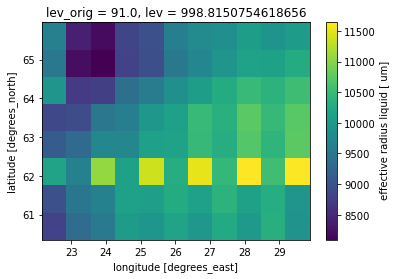

In [123]:
ds_ifs['re_liq_cltop'].count('time').plot()

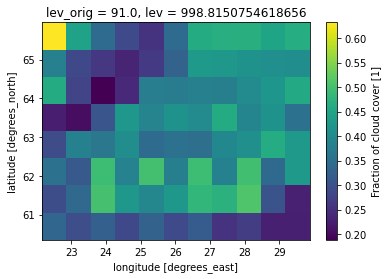

In [124]:
ds_ifs['cl_frac_where_cltime_pos'].mean('time').plot()

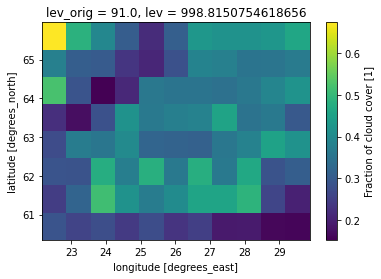

In [125]:
ds_ifs['cc_all'].mean('time').plot()

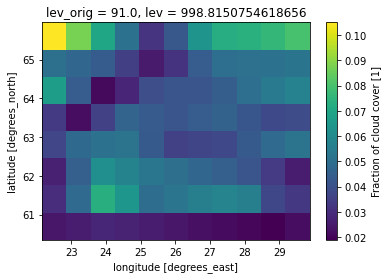

In [126]:
ds_ifs['cc'].mean('time').plot()

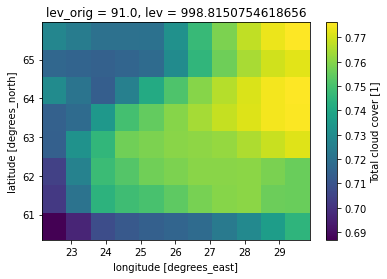

In [127]:
ds_ifs['ttc'].mean('time').plot()

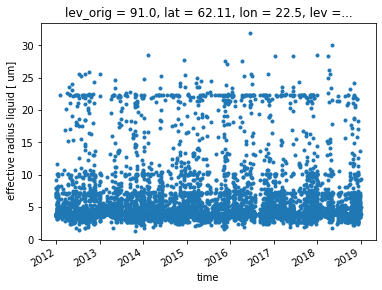

In [128]:
ds_ifs['re_liq'].isel(lat=2, lon=0).plot(x='time', linewidth=0, marker='.')

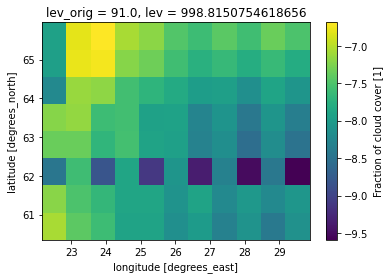

In [129]:
ds_ifs['argmax'].mean('time').plot()

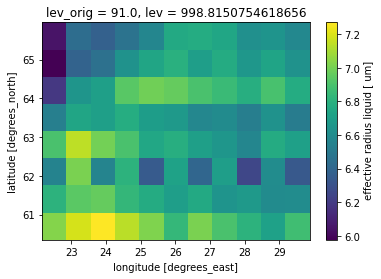

In [130]:
ds_ifs['re_liq_cltop'].mean('time').plot()

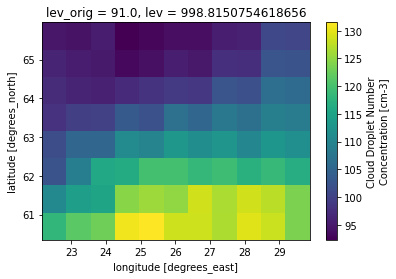

In [131]:
ds_ifs['cdnc_incld_cltop'].mean('time').plot()

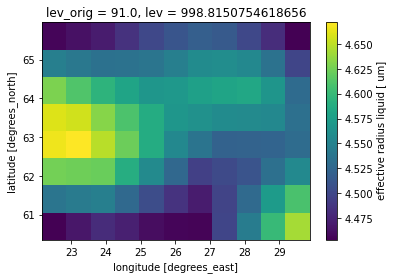

In [132]:
ds_ifs['re_liq'].mean('time').plot()

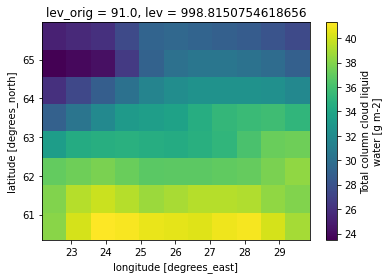

In [133]:
ds_ifs['tclw'].mean('time').plot()

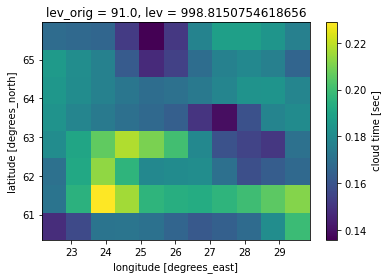

In [134]:
ds_ifs['cloud_time_norm'].mean('time').plot()

#### Masking and computing vars

##### *Mask values where cloud fraction is less than 10 percent

In [135]:
xr.set_options(keep_attrs=True)

In [136]:
ds_ifs = ds_ifs.where(ds_ifs['cc_cltop'] > .1)

##### *Mask if ice water path more than 5% of total water path

In [137]:
ds_ifs = ds_ifs.where(ds_ifs['liq_frac_cwp'] > .95)

(array([ 6542.,  6684.,  6922.,  7153.,  7261.,  7742.,  8408.,  9696.,
        12315., 57010.]),
 array([0.9500115 , 0.95501035, 0.9600092 , 0.965008  , 0.9700069 ,
        0.97500575, 0.9800046 , 0.9850035 , 0.9900023 , 0.99500114,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

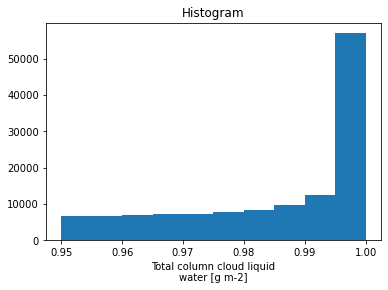

In [138]:
ds_ifs['liq_frac_cwp'].plot()

#### Shift timezone

In [139]:

with ProgressBar():
    ds_ifs.load()

if ds_ifs['time'].attrs['timezone'] == 'utc':
    ds_ifs['time'] = ds_ifs['time'].to_pandas().index + timedelta(hours=2)
    ds_ifs['time'].attrs['timezone'] = 'utc+2'
    print('shifted time by +2')
    # dic_ds[k] = _ds

shifted time by +2


#### Use station data computed before:

In [140]:
df_comb_station = dic_df_station[model_name_ec_earth][case_name_ec_earth]

In [141]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

(array([1.7000e+01, 5.8000e+01, 8.0000e+01, 6.1500e+02, 7.3900e+03,
        3.2013e+04, 3.8028e+04, 4.0010e+04, 1.0660e+04, 8.6200e+02]),
 array([244.94691, 250.91177, 256.87665, 262.84152, 268.8064 , 274.77124,
        280.7361 , 286.701  , 292.66583, 298.6307 , 304.59558],
       dtype=float32),
 <BarContainer object of 10 artists>)

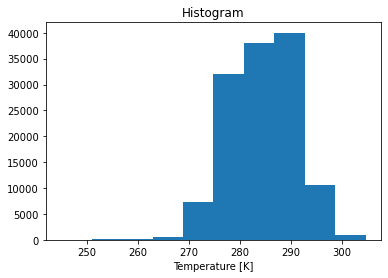

In [142]:
ds_ifs['temp'].plot()

##### Check time against station data

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


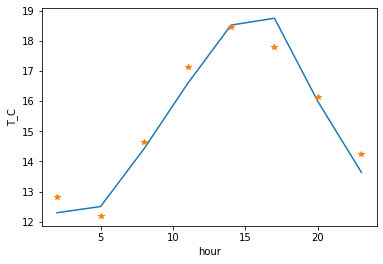

In [143]:
ds_ifs['hour'] = ds_ifs['time.hour']
_ds1 = ds_ifs.sel(time=slice('2012-07', '2012-08'))
_ds2 = ds_comb_station.sel(time=slice('2012-07', '2012-08'))
(_ds1['temp'] - 273.15).groupby(_ds1['hour']).mean().sel(lat=lat_station, lon=lon_station, method='nearest').plot()
_ds2['T_C'].groupby(_ds2['time.hour']).mean().plot(marker='*')

In [144]:
varl_station_ec_earth = [
    'CCN0.20',
    'CCN1.00',
    'M_BCACS',
    'M_BCAII',
    'M_BCAIS',
    'M_BCCOS',
    'M_DUACI',
    'M_DUACS',
    'M_DUCOI',
    'M_DUCOS',
    'M_POMACS',
    'M_POMAII',
    'M_POMAIS',
    'M_POMCOS',
    'M_SO4ACS',
    'M_SO4COS',
    'M_SO4NUS',
    'M_SOAACS',
    'M_SOAAII',
    'M_SOAAIS',
    'M_SOACOS',
    'M_SOANUS',
    'M_SSACS',
    'M_SSCOS',
    'OA',
    'SOA',
    'N_ACI',
    'N_ACS',
    'N_AII',
    'N_AIS',
    'N_COI',
    'N_COS',
    'N_NUS',
    'RDRY_ACS',
    'RDRY_AIS',
    'RDRY_COS',
    'RDRY_NUS',
    'RWET_ACI',
    'RWET_ACS',
    'RWET_AII',
    'RWET_AIS',
    'RWET_COI',
    'RWET_COS',
    'RWET_NUS',
    'emiisop',
    'emiterp',
    'T',
    'DDRY_NUS',
    'DDRY_AIS',
    'DDRY_ACS',
    'DDRY_COS',
    'DWET_AII',
    'DWET_ACI',
    'DWET_COI',
    'N50',
    'N70',
    'N100',
    'N150',
    'N200',
    'N500',
    'N50-500',
    'N70-500',
    'N100-500',
    'N150-500',
    'N200-500',
    'N50-500_STP',
    'N100-500_STP',
    'N200-500_STP',
    'N50_STP',
    'N100_STP',
    'N200_STP',
    'OA_STP',
    'POM',
    'SOA',
    'SOA2',
    'T_C',

]

In [145]:

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_station_ec_earth).union(set(varl_st_computed))))

In [146]:
ds_smll = ds_ifs[['temp']]

In [147]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

N200-500
replacing N200-500 
M_SO4COS
replacing M_SO4COS 
M_BCAII
replacing M_BCAII 
OA_amb
replacing OA_amb 
N50-500
replacing N50-500 
RWET_ACI
replacing RWET_ACI 
M_SO4ACS
replacing M_SO4ACS 
N_NUS
replacing N_NUS 
DWET_COI
replacing DWET_COI 
DDRY_NUS
replacing DDRY_NUS 
RWET_COS
replacing RWET_COS 
N_AIS
replacing N_AIS 
N_COS
replacing N_COS 
M_BCCOS
replacing M_BCCOS 
SOA
replacing SOA 
emiterp
replacing emiterp 
M_SSACS
replacing M_SSACS 
DWET_ACI
replacing DWET_ACI 
N50_STP
replacing N50_STP 
M_SOACOS
replacing M_SOACOS 
M_SO4NUS
replacing M_SO4NUS 
N_ACI
replacing N_ACI 
POM
replacing POM 
M_POMAII
replacing M_POMAII 
N500
replacing N500 
N150
replacing N150 
N70
replacing N70 
DDRY_AIS
replacing DDRY_AIS 
M_POMCOS
replacing M_POMCOS 
DWET_AII
replacing DWET_AII 
M_POMAIS
replacing M_POMAIS 
N200_STP
replacing N200_STP 
N_COI
replacing N_COI 
M_SOAAII
replacing M_SOAAII 
CCN0.20
replacing CCN0.20 
N150-500
replacing N150-500 
N100_STP
replacing N100_STP 
emiisop
replacing emi

##### Replace all values by station values

In [148]:
for v in varl_tmp:
    ds_ifs[v] = ds_smll[v]

#### Final adjustments


In [149]:
dic_ds = dict()
dic_ds[case_name_ec_earth] = ds_ifs

##### Rename variables

In [150]:
# calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ec_earth_cloud)

In [151]:
ds = dic_ds[key]

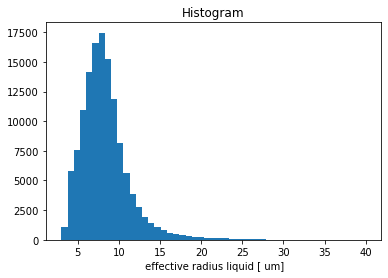

In [152]:
ds['r_eff'].plot(bins=np.linspace(3, 40));

In [153]:
ds['CWP_unweigth'] = ds['tclw']

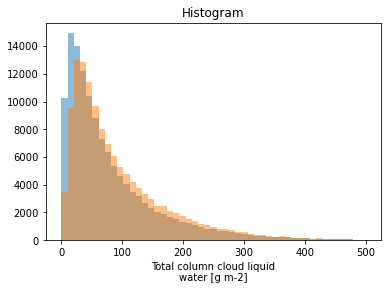

In [154]:
ds['CWP_unweigth'].plot(bins=np.linspace(0, 500), alpha=.5);
ds['CWP'].plot(bins=np.linspace(0, 500), alpha=.5);

##### Controle plots normalizing by cloud fraction

Text(0.5, 1.0, 'CWP divided by cloud fraction')

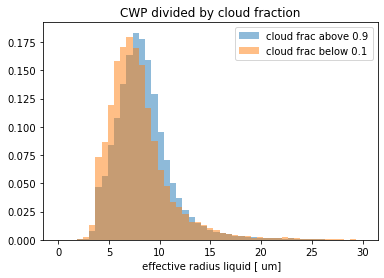

In [155]:
ds['r_eff'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc'] < .4).plot(bins=np.linspace(0, 30), alpha=.5, density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP divided by cloud fraction')

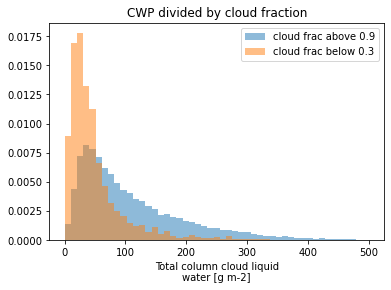

In [156]:
ds['CWP'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP'].where(ds['ttc'] < .3).plot(bins=np.linspace(0, 500), alpha=.5, density=True, label='cloud frac below 0.3');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP not divided ')

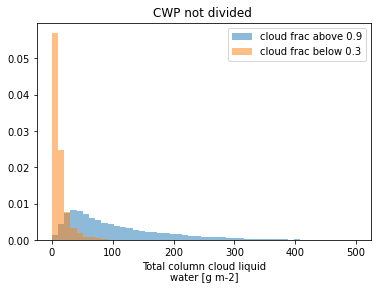

In [157]:
ds['CWP_unweigth'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 500), alpha=.5, density=True,
                                              label='cloud frac above 0.9');
ds['CWP_unweigth'].where(ds['ttc'] < .3).plot(bins=np.linspace(0, 500), alpha=.5, density=True,
                                              label='cloud frac below 0.3');
plt.legend()
plt.title('CWP not divided ')

#### Final save csv

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 50<CWP and 800>CWP!
Masking with r_eff>1!
cloud and resampled
cloud_avg median
station


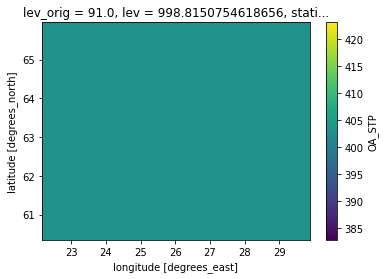

merge
df1


In [158]:
for seas in calc_seasons:
    _fn_csv = fn_final_ec_earth_csv_stem.parent / (fn_final_ec_earth_csv_stem.name + seas + '.csv')
    print(_fn_csv)

    if True:  # not _fn_csv.exists():
        # for key in dic_ds.keys():

        dic_df = get_dic_df_mod(dic_ds,
                                select_hours_clouds=True,
                                summer_months=season2month[seas],
                                mask_cloud_values=True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds=dict(min_reff=r_eff_lim,
                                                       min_cwp=cld_water_path_above,
                                                       tau_bounds=tau_lims
                                                       ),

                                )

        df_mod = dic_df[case_name_ec_earth]
        # with ProgressBar():
        # df_mod = df_mod.dropna()
        df_mod.to_csv(_fn_csv)

<AxesSubplot:ylabel='Frequency'>

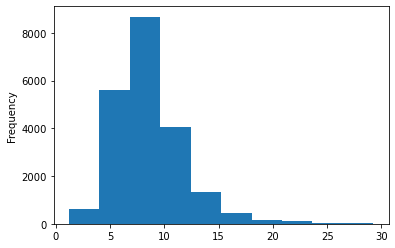

In [159]:
df_mod['r_eff'].plot.hist()

In [160]:
print('Done')

Done


## UKESM

In [161]:

case_name_ukesm = 'AEROCOMTRAJ'
case_name = case_name_ukesm
time_res = 'hour'
space_res = 'locations'
model_name_ukesm = 'UKESM'
model_name = model_name_ukesm

#### Input path

In [162]:
input_path_ukesm = path_extract_latlon_outdata / model_name_ukesm / case_name_ukesm

In [163]:

cases_ukesm = [case_name_ukesm]

In [164]:
from bs_fdbck_clean.util.BSOA_datamanip.ukesm import fix_units_ukesm, extract_2D_cloud_time_ukesm

#### Station variables  and others

In [165]:
varl_st_ukesm = [
'Mass_Conc_OM_NS',
'Mass_Conc_OM_KS',
'Mass_Conc_OM_KI',
'Mass_Conc_OM_AS',
'Mass_Conc_OM_CS',
'mmrtr_OM_NS',
'mmrtr_OM_KS',
'mmrtr_OM_KI',
'mmrtr_OM_AS',
'mmrtr_OM_CS',
'nconcNS',
'nconcKS',
'nconcKI',
'nconcAS',
'nconcCS',
'ddryNS',
'ddryKS',
'ddryKI',
'ddryAS',
'ddryCS',
'Temp',
    'N100',
    'N50',
    'N200',
    'OA',
    'N100_STP',
    'N50_STP',
    'N200_STP',
    'OA_STP',
    'T_C',
]

varl_cl_ukesm = [
    'Reff_2d_distrib_x_weight',
    'Reff_2d_x_weight_warm_cloud',
    'area_cloud_fraction_in_each_layer',
    'bulk_cloud_fraction_in_each_layer',
    'cloud_ice_content_after_ls_precip',
    'dry_rho',
    'frozen_cloud_fraction_in_each_layer',
    'liq_cloud_fraction_in_each_layer',
    'qcf',
    'qcl',
    'supercooled_liq_water_content',
    'weight_Reff_2d_distrib',
    'weight_Reff_2d',
    'cdnc_top_cloud_x_weight',
    'weight_of_cdnc_top_cloud',
    'ls_lwp',
    'ls_iwp',
    'conv_iwp',
    'conv_lwp',
    'rho',
    'layer_thickness',
    
]



#### Filenames:

In [166]:
fn_final_ukesm = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ukesm_csv = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_wet_season.csv'
fn_final_ukesm_csv_stem = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

#### Open data area around station

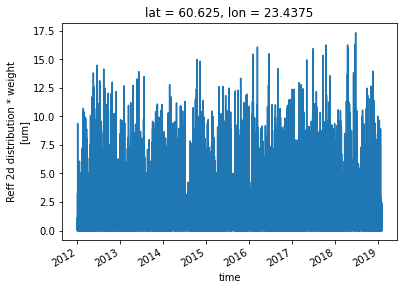

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_Reff_2d_distrib_x_weight_concat_subs_22.0-30.0_60.0-66.0.nc


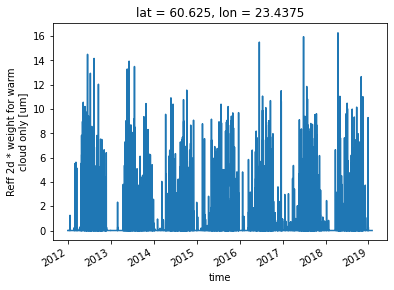

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_Reff_2d_x_weight_warm_cloud_concat_subs_22.0-30.0_60.0-66.0.nc


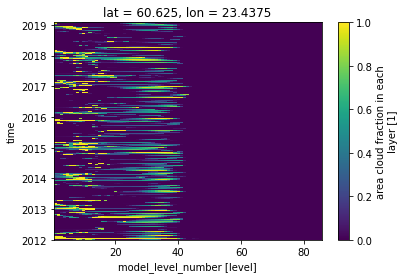

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_area_cloud_fraction_in_each_layer_concat_subs_22.0-30.0_60.0-66.0.nc


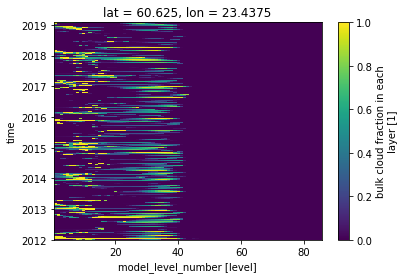

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_bulk_cloud_fraction_in_each_layer_concat_subs_22.0-30.0_60.0-66.0.nc


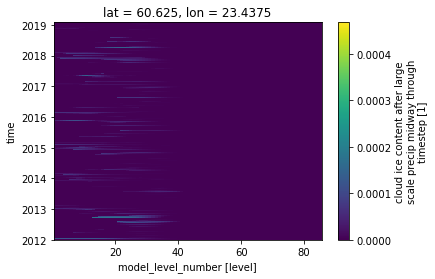

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_cloud_ice_content_after_ls_precip_concat_subs_22.0-30.0_60.0-66.0.nc
Adding dry_rho to rho filelist: /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_dry_rho_concat_subs_22.0-30.0_60.0-66.0.nc


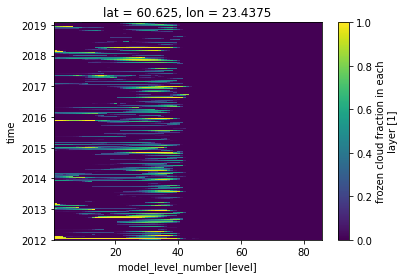

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_frozen_cloud_fraction_in_each_layer_concat_subs_22.0-30.0_60.0-66.0.nc


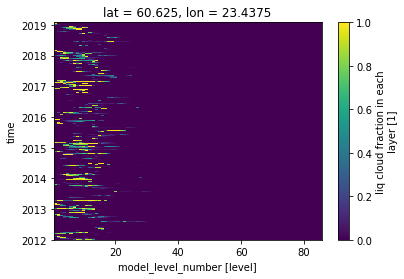

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_liq_cloud_fraction_in_each_layer_concat_subs_22.0-30.0_60.0-66.0.nc


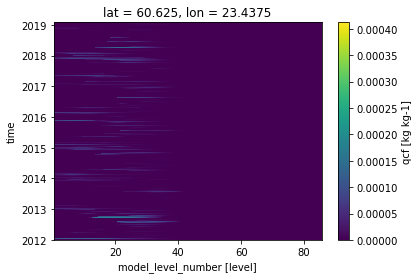

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_qcf_concat_subs_22.0-30.0_60.0-66.0.nc


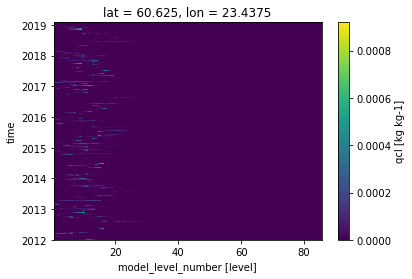

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_qcl_concat_subs_22.0-30.0_60.0-66.0.nc


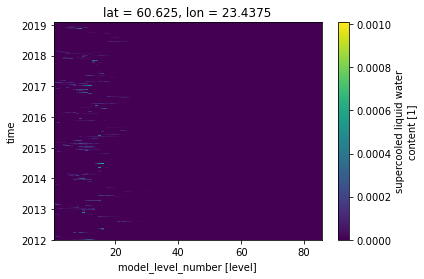

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_supercooled_liq_water_content_concat_subs_22.0-30.0_60.0-66.0.nc


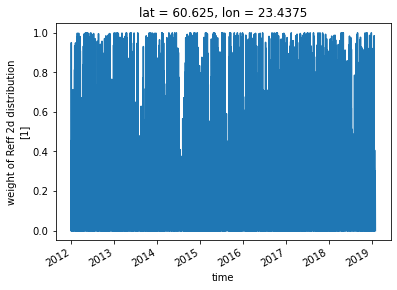

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_weight_Reff_2d_distrib_concat_subs_22.0-30.0_60.0-66.0.nc


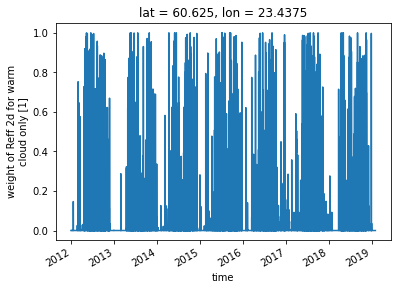

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_weight_Reff_2d_concat_subs_22.0-30.0_60.0-66.0.nc


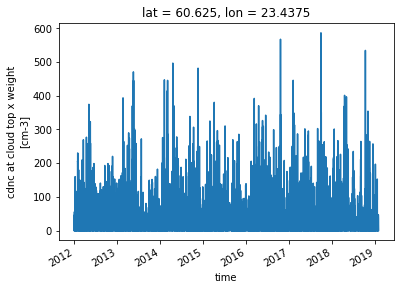

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_cdnc_top_cloud_x_weight_concat_subs_22.0-30.0_60.0-66.0.nc


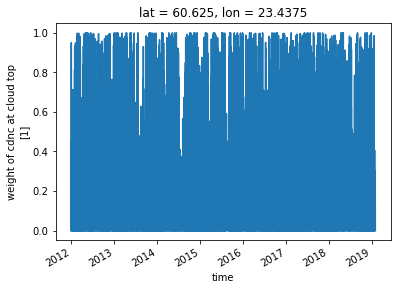

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_weight_of_cdnc_top_cloud_concat_subs_22.0-30.0_60.0-66.0.nc


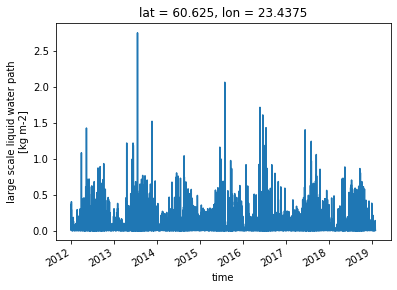

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ls_lwp_concat_subs_22.0-30.0_60.0-66.0.nc


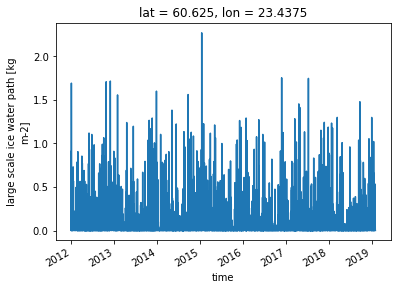

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ls_iwp_concat_subs_22.0-30.0_60.0-66.0.nc


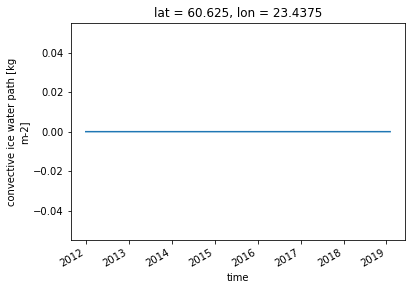

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_conv_iwp_concat_subs_22.0-30.0_60.0-66.0.nc


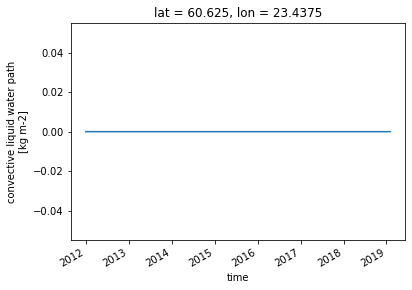

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_conv_lwp_concat_subs_22.0-30.0_60.0-66.0.nc
Adding rho to rho filelist: /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_rho_concat_subs_22.0-30.0_60.0-66.0.nc
ups, coult not plot
Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_layer_thickness_concat_subs_22.0-30.0_60.0-66.0.nc
Mass_Conc_OM_NS not found
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_Mass_Conc_OM_NS_concat_subs_22.0-30.0_60.0-66.0.nc
Mass_Conc_OM_KS not found
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_Mass_Conc_OM_KS_concat_subs_22.0-3

In [167]:
fl_open = []
fl_rho = []

for v in varl_cl_ukesm + varl_st_ukesm:
    fn = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    #print(fn)
    if fn.exists():
        if (v=='dry_rho') or (v=='rho'):
            fl_rho.append(fn)
            print(f'Adding {v} to rho filelist: {fn}')
            continue
            
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        try:
            _ds[v].isel(lat=0,lon=0).plot()
            plt.show()
        except:
            print('ups, coult not plot')
        print(f'Opening {fn}')
    else:
        print(f'{v} not found')
        print(fn)

#### Open files, decode time etc

In [168]:
fl_open = list(set(fl_open))

#### Some timestamps have small errors in them (20 min off the hour), so we round some files:


In [169]:


ls_ds = []
for f in fl_open:
    _ds = xr.open_dataset(f, decode_times=False)
    if 'time' in _ds.coords:
        if 'hours since' in _ds['time'].units:
            _ds['time'] = np.floor(_ds['time'])
            _ds = xr.decode_cf(_ds)
    ls_ds.append(_ds)

ds_all = xr.merge(ls_ds)

In [170]:
ls_ds_rho = []
for f in fl_rho:
    _ds = xr.open_dataset(f, decode_times=False)
    if 'time' in _ds.coords:
        if 'hours since' in _ds['time'].units:
            _ds['time'] = np.floor(_ds['time'])
            _ds = xr.decode_cf(_ds)
    ls_ds_rho.append(_ds)

ds_rho = xr.merge(ls_ds_rho)

### Somehow the rho has different level than the other, but this is due to it being at the grid box interface, not mid point, so we can ignore it

In [171]:
for v in ['rho','dry_rho']:
    ds_all[v] = ds_rho[v]

In [172]:
fn_final_ukesm

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0.nc')

### layer thickness has the wrong vertical coordinate name:

In [173]:
ds_all['layer'] = ds_all['layer'].swap_dims({'lev':'model_level'})

In [174]:
ds_all['ls_lwp'].quantile(.95)*1000

<xarray.DataArray 'ls_lwp' ()>
array(208.49609375)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            kg m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [175]:
from bs_fdbck_clean.util.BSOA_datamanip.ukesm import extract_2D_cloud_time_ukesm, change_units_and_compute_vars_ukesm

In [176]:
if True:#not fn_final_ukesm.exists():
    #ds_all = xr.open_mfdataset(fl_open, decode_cf=False)
    # ds_iso = xr.open_dataset(fl_open[21])
    # ds = xr.merge([ds_iso,ds])
    #ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)

    # ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_ukesm(ds_all)

    # ds_sel = ds_all.sel(lat = lat_station, lon= lon_station, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    #ds_all = ds_all.drop(['hyai', 'hybi', 'hyam', 'hybm']).squeeze()
    if 'model_level' in ds_all.coords:
        ds_all = ds_all.isel(model_level=(-1-model_lev_i))

    # ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam, lon = lon_station, lat = lat_station)

    ds_all = change_units_and_compute_vars_ukesm(ds_all)

    delayed_obj = ds_all.to_netcdf(fn_final_ukesm, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

converting units lwp
converting units iwp
['conv_lwp', 'Reff_2d_x_weight_warm_cloud', 'cdnc_top_cloud_x_weight', 'frozen_cloud_fraction_in_each_layer', 'level_height', 'sigma', 'qcf', 'ls_lwp', 'Reff_2d_distrib_x_weight', 'weight_Reff_2d_distrib', 'liq_cloud_fraction_in_each_layer', 'weight_Reff_2d', 'bulk_cloud_fraction_in_each_layer', 'conv_iwp', 'weight_of_cdnc_top_cloud', 'cloud_ice_content_after_ls_precip', 'ls_iwp', 'layer', 'area_cloud_fraction_in_each_layer', 't_at_eot', 'supercooled_liq_water_content', 'qcl', 'rho', 'dry_rho', 'r_eff', 'r_eff2', 'max_cloud_cover', 'max_cloud_fraction', 'lwp', 'iwp', 'lwp_incld', 'computed_lwp_sum', 'computed_lwp_sum_incld', 'computed_iwp_sum', 'computed_iwp_sum_incld', 'liq_frac_cwp', 'OA']
{'conv_lwp': 'conv_lwp', 'Reff_2d_x_weight_warm_cloud': 'Reff_2d_x_weight_warm_cloud', 'cdnc_top_cloud_x_weight': 'cdnc_top_cloud_x_weight', 'frozen_cloud_fraction_in_each_layer': 'frozen_cloud_fraction_in_each_layer', 'qcf': 'qcf', 'ls_lwp': 'ls_lwp', 'Ref

In [177]:
    delayed_obj = ds_all.to_netcdf(fn_final_ukesm, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

hey
[########################################] | 100% Completed |  0.1s


In [178]:
ds_all['lwp'].quantile(.95)

<xarray.DataArray 'lwp' ()>
array(208.49609375)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [179]:
from bs_fdbck_clean.util.BSOA_datamanip.ukesm import get_rndic_ukesm

In [180]:
ds_all = xr.open_dataset(fn_final_ukesm)
ds_all['time'].attrs['timezone'] = 'utc'


#### Add variables from station data to imitate using station measurements

In [181]:
df_comb_station = dic_df_station[model_name_ukesm][case_name_ukesm]

In [182]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

In [183]:
ds_comb_station

<xarray.Dataset>
Dimensions:                        (time: 20456, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2012-01-01T01:00:00 ...
  * station                        (station) <U3 'SMR'
Data variables: (12/46)
    lev                            (time) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Mass_Conc_OM_AS                (time) float64 0.03878 0.03498 ... 0.03932
    Mass_Conc_OM_CS                (time) float64 2.059e-13 ... 4.102e-14
    Mass_Conc_OM_KI                (time) float64 0.2234 0.3986 ... 0.02664
    Mass_Conc_OM_KS                (time) float64 0.0002515 ... 5.639e-05
    Mass_Conc_OM_NS                (time) float64 3.923e-07 ... 5.049e-07
    ...                             ...
    density                        (time) float64 1.287 1.288 ... 1.271 1.267
    ambient2stp_correction_factor  (time) float64 1.004 1.003 ... 1.017 1.02
    OA_STP                         (time) float64 0.2635 0.4353 ... 0.06732
    N100_STP                       (time) float64 310.6 475.2 ... 115.7 112.1
    N200_STP                       (time) float64 79.27 97.0 ... 26.17 28.01
    N50_STP                        (time) float64 525.0 893.5 ... 139.6 137.2

In [184]:
ds_all['lwp'].quantile(.95)

<xarray.DataArray 'lwp' ()>
array(208.49609375)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

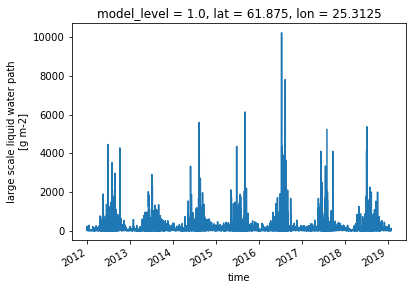

In [185]:
ds_all['lwp_incld'].isel(lat=1, lon=1).plot()

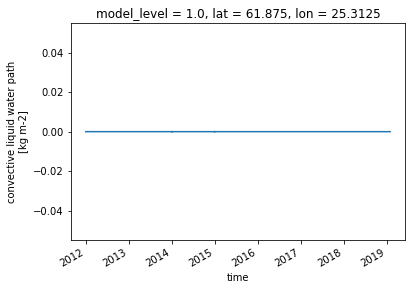

In [186]:
ds_all['conv_lwp'].isel(lat=1, lon=1).plot()

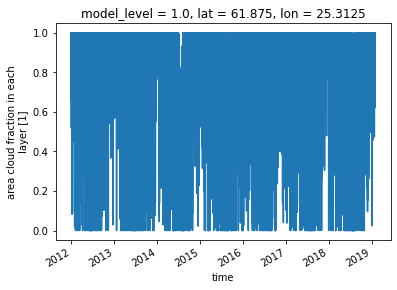

In [187]:
ds_all['max_cloud_cover'].isel(lat=1, lon=1).plot()

#### Finally produce daily median dataset:

In [188]:
dic_ds = dict()
dic_ds[case_name_ukesm] = ds_all

##### Controle plots

(array([2.51639e+05, 7.18630e+04, 3.39310e+04, 1.56540e+04, 8.12400e+03,
        4.66700e+03, 2.96400e+03, 1.93100e+03, 1.42500e+03, 1.08400e+03,
        8.27000e+02, 6.73000e+02, 5.25000e+02, 4.62000e+02, 3.67000e+02,
        3.35000e+02, 2.86000e+02, 2.50000e+02, 2.41000e+02]),
 array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
         210.52631579,  263.15789474,  315.78947368,  368.42105263,
         421.05263158,  473.68421053,  526.31578947,  578.94736842,
         631.57894737,  684.21052632,  736.84210526,  789.47368421,
         842.10526316,  894.73684211,  947.36842105, 1000.        ]),
 <BarContainer object of 19 artists>)

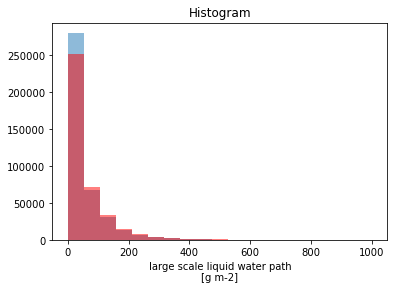

In [189]:
ds_all['lwp'].plot(bins=np.linspace(0, 1000, 20), alpha=.5, )

ds_all['lwp_incld'].plot(bins=np.linspace(0, 1000, 20), alpha=.5, color='r')

(array([ 1171.,   870.,  2070.,  1108.,  2116.,  1190.,  2303.,  2391.,
         2504.,  2568.,  3456.,  2988.,  3716.,  3902.,  4701.,  4969.,
         5420.,  6100.,  6519.,  7255.,  8024.,  8836.,  9507., 10349.,
        11619., 12296., 13482., 14206., 15295., 15633., 15409., 14567.,
        13352., 12193., 10245.,  8270.,  6717.,  5367.,  4023.,  3211.,
         2453.,  1937.,  1534.,  1224.,   994.,   815.,   686.,   569.,
          444.]),
 array([1.00000000e+00, 1.15681872e+00, 1.33822954e+00, 1.54808898e+00,
        1.79085830e+00, 2.07169840e+00, 2.39657948e+00, 2.77240800e+00,
        3.20717346e+00, 3.71011828e+00, 4.29193426e+00, 4.96498988e+00,
        5.74359321e+00, 6.64429612e+00, 7.68624610e+00, 8.89159334e+00,
        1.02859616e+01, 1.18989929e+01, 1.37649776e+01, 1.59235837e+01,
        1.84206997e+01, 2.13094102e+01, 2.46511245e+01, 2.85168821e+01,
        3.29888630e+01, 3.81621341e+01, 4.41466709e+01, 5.10696951e+01,
        5.90783791e+01, 6.83429746e+01, 7.9060

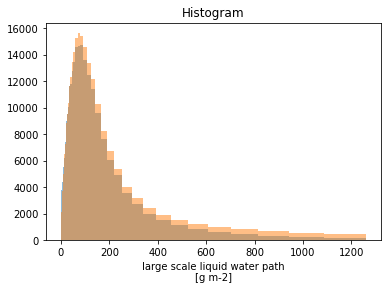

In [190]:
f, ax = plt.subplots(1)
ds_all['lwp'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)
ds_all['lwp_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)

#### Masking and computing vars

#### *Mask where cloud fraction is above 10 percent 

(array([ 14505.,  18864.,  19718.,  19746.,  18736.,  17812.,  17286.,
         18603.,  26718., 211045.]),
 array([0.10009766, 0.19008788, 0.2800781 , 0.37006837, 0.4600586 ,
        0.5500488 , 0.6400391 , 0.7300293 , 0.82001954, 0.91000974,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

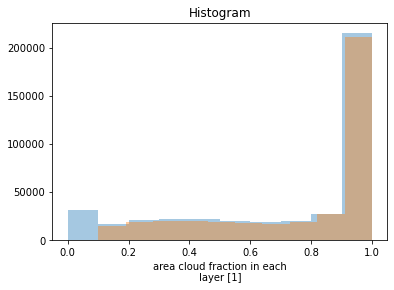

In [191]:
ds_all['max_cloud_cover'].plot.hist(alpha=.4)
ds_all['max_cloud_cover'].where(ds_all['max_cloud_cover']>0.1).plot.hist(alpha=.4)

##### *Mask if ice water path more than 5% of total water path

In [192]:
ds_all = ds_all.where(ds_all['liq_frac_cwp'] > .95)

(array([ 4200.,  4869.,  3200.,  2562.,  1941.,  1819.,  2021.,  3010.,
         6508., 42631.]),
 array([0.10009766, 0.19008788, 0.2800781 , 0.37006837, 0.4600586 ,
        0.5500488 , 0.6400391 , 0.7300293 , 0.82001954, 0.91000974,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

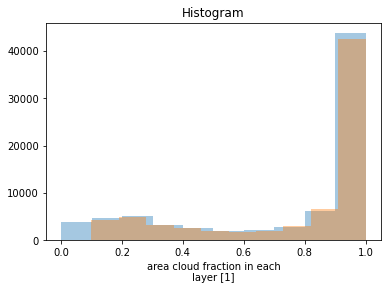

In [193]:
ds_all['max_cloud_cover'].plot.hist(alpha=.4)
ds_all['max_cloud_cover'].where(ds_all['max_cloud_cover']>0.1).plot.hist(alpha=.4)

In [194]:
ds_all = ds_all.where(ds_all['max_cloud_cover']>0.1)

### *Mask where cloud top weight less than 10 percent:

(array([3811., 4726., 4821., 4545., 4116., 3489., 2884., 2227., 1839.,
        1465., 1119.,  968.,  735.,  585.,  456.,  430.,  343.,  269.,
         245.,  196.,  147.,  167.,  141.,  110.,  102.,   96.,   76.,
          69.,   71.,   73.,   51.,   66.,   52.,   43.,   38.,   43.,
          37.,   40.,   29.,   28.,   31.,   37.,   28.,   26.,   21.,
          27.,   20.,   28.,   21.]),
 array([  0.        ,  16.32653061,  32.65306122,  48.97959184,
         65.30612245,  81.63265306,  97.95918367, 114.28571429,
        130.6122449 , 146.93877551, 163.26530612, 179.59183673,
        195.91836735, 212.24489796, 228.57142857, 244.89795918,
        261.2244898 , 277.55102041, 293.87755102, 310.20408163,
        326.53061224, 342.85714286, 359.18367347, 375.51020408,
        391.83673469, 408.16326531, 424.48979592, 440.81632653,
        457.14285714, 473.46938776, 489.79591837, 506.12244898,
        522.44897959, 538.7755102 , 555.10204082, 571.42857143,
        587.75510204, 604.08163

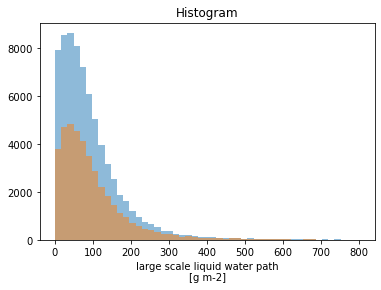

In [195]:
ds_all['lwp_incld'].plot.hist(bins=np.linspace(0,800), alpha =.5)

ds_all['lwp_incld'].where(ds_all['weight_of_cdnc_top_cloud']>0.1).plot.hist(bins=np.linspace(0,800), alpha =.5)

In [196]:
ds_all = ds_all.where(ds_all['weight_Reff_2d_distrib']>0.1)

#### UKESM Shift time step to start of period to be consistent with measurements and other models

In [197]:
if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=1)
    #ds_all['time'].attrs['timezone'] = 'utc+2'
    ds_all['time'].attrs['timezone'] = 'utc'
    
    print('shifted time by -1 for UKESM')

shifted time by -1 for UKESM


#### Shift timezone

In [198]:

with ProgressBar():
    ds_all.load()

if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index + timedelta(hours=2)
    ds_all['time'].attrs['timezone'] = 'utc+2'
    print('shifted time by +2')
    # dic_ds[k] = _ds

shifted time by +2


#### Broadcast computed variables so that only station value is in the gridcells. 

In [199]:
ds_all

<xarray.Dataset>
Dimensions:                              (time: 20704, lat: 5, lon: 4)
Coordinates:
    model_level                          float32 1.0
  * time                                 (time) datetime64[ns] 2012-01-01T01:...
  * lat                                  (lat) float32 60.62 61.88 ... 65.62
  * lon                                  (lon) float32 23.44 25.31 27.19 29.06
Data variables: (12/37)
    conv_lwp                             (time, lat, lon) float32 nan ... nan
    Reff_2d_x_weight_warm_cloud          (time, lat, lon) float32 nan ... nan
    cdnc_top_cloud_x_weight              (time, lat, lon) float32 nan ... nan
    frozen_cloud_fraction_in_each_layer  (time, lat, lon) float32 nan ... nan
    level_height                         (time, lat, lon) float64 nan ... nan
    sigma                                (time, lat, lon) float64 nan ... nan
    ...                                   ...
    computed_lwp_sum                     (time, lat, lon) float32 nan ... nan
    computed_lwp_sum_incld               (time, lat, lon) float32 nan ... nan
    computed_iwp_sum                     (time, lat, lon) float32 nan ... nan
    computed_iwp_sum_incld               (time, lat, lon) float32 nan ... nan
    liq_frac_cwp                         (time, lat, lon) float32 nan ... nan
    OA                                   (time, lat, lon) float64 nan ... nan
Attributes:
    conventions:  CF-1.7
    source:       Met Office Unified Model
    version:      11.1
    model:        UKESM1.0
    realm:        atmosphere
    institution:  CEMPS, University of Exeter
    project:      AeroCom
    experiment:   GCMTraj
    history:      Mon Mar 20 19:37:36 2023: ncrcat -O /proj/bolinc/users/x_sa...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [200]:
ds_all['lwp'].where(ds_all['max_cloud_cover']>.10).quantile(0.95)

<xarray.DataArray 'lwp' ()>
array(232.91015625)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [201]:
ds_all['lwp_incld'].where(ds_all['max_cloud_cover']>.10).quantile(0.95)

<xarray.DataArray 'lwp_incld' ()>
array(362.39912415)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [202]:
ds_smll = ds_all[['qcf']]

In [203]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

##### Check time by comparing to station dataset

In [204]:
_da = ds_comb_station['T_C'].sel(time=slice('2013','2018'))

In [205]:
_da2 = (ds_all['Temp']-273.15).sel(time=slice('2013','2018')).sel(lat=lat_station, lon=lon_station, method='nearest')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


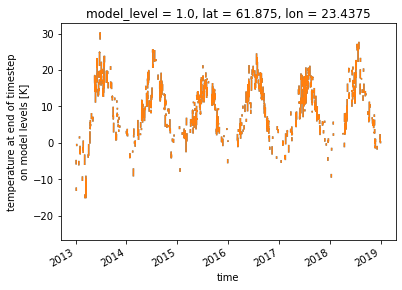

In [206]:
_da.where(_da2.notnull()).plot()
_da2.plot()

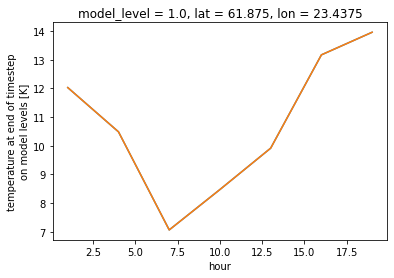

In [207]:
_da.where(_da2.notnull()).groupby(_da2['time.hour']).mean().plot()
_da2.groupby(_da2['time.hour']).mean().plot()

<AxesSubplot:xlabel='time'>

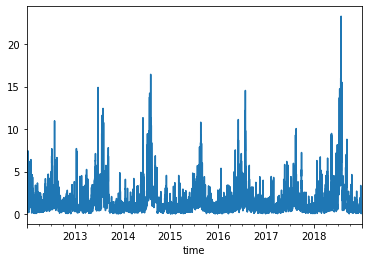

In [208]:
df_comb_station['OA_STP'].plot()

In [209]:
varl_st_ukesm

['Mass_Conc_OM_NS',
 'Mass_Conc_OM_KS',
 'Mass_Conc_OM_KI',
 'Mass_Conc_OM_AS',
 'Mass_Conc_OM_CS',
 'mmrtr_OM_NS',
 'mmrtr_OM_KS',
 'mmrtr_OM_KI',
 'mmrtr_OM_AS',
 'mmrtr_OM_CS',
 'nconcNS',
 'nconcKS',
 'nconcKI',
 'nconcAS',
 'nconcCS',
 'ddryNS',
 'ddryKS',
 'ddryKI',
 'ddryAS',
 'ddryCS',
 'Temp',
 'N100',
 'N50',
 'N200',
 'OA',
 'N100_STP',
 'N50_STP',
 'N200_STP',
 'OA_STP',
 'T_C']

In [210]:
varl_tmp = varl_st_ukesm

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [211]:
varl_tmp

['mmrtr_OM_CS',
 'Mass_Conc_OM_AS',
 'Mass_Conc_OM_CS',
 'Mass_Conc_OM_KI',
 'N50_STP',
 'ddryKS',
 'Mass_Conc_OM_KS',
 'N200_STP',
 'mmrtr_OM_NS',
 'N100_STP',
 'mmrtr_OM_KS',
 'OA_STP',
 'ddryNS',
 'ddryAS',
 'mmrtr_OM_KI',
 'mmrtr_OM_AS',
 'T_C',
 'ddryKI',
 'ddryCS',
 'Mass_Conc_OM_NS',
 'nconcKS',
 'nconcNS',
 'nconcCS',
 'nconcKI',
 'nconcAS']

In [212]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

mmrtr_OM_CS
replacing mmrtr_OM_CS 
Mass_Conc_OM_AS
replacing Mass_Conc_OM_AS 
Mass_Conc_OM_CS
replacing Mass_Conc_OM_CS 
Mass_Conc_OM_KI
replacing Mass_Conc_OM_KI 
N50_STP
replacing N50_STP 
ddryKS
replacing ddryKS 
Mass_Conc_OM_KS
replacing Mass_Conc_OM_KS 
N200_STP
replacing N200_STP 
mmrtr_OM_NS
replacing mmrtr_OM_NS 
N100_STP
replacing N100_STP 
mmrtr_OM_KS
replacing mmrtr_OM_KS 
OA_STP
replacing OA_STP 
ddryNS
replacing ddryNS 
ddryAS
replacing ddryAS 
mmrtr_OM_KI
replacing mmrtr_OM_KI 
mmrtr_OM_AS
replacing mmrtr_OM_AS 
T_C
replacing T_C 
ddryKI
replacing ddryKI 
ddryCS
replacing ddryCS 
Mass_Conc_OM_NS
replacing Mass_Conc_OM_NS 
nconcKS
replacing nconcKS 
nconcNS
replacing nconcNS 
nconcCS
replacing nconcCS 
nconcKI
replacing nconcKI 
nconcAS
replacing nconcAS 


#### Replace all values by station values

In [213]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

#### Final steps

In [214]:
dic_ds = dict()
dic_ds[case_name_ukesm] = ds_all

##### Rename vars

In [215]:
from bs_fdbck_clean.util.BSOA_datamanip import rn_dic_ukesm_cloud

In [216]:
rn_dic_ukesm_cloud

{'lwp_incld': 'CWP', 'r_eff': 'r_eff'}

In [217]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ukesm_cloud)

#### Save final csv

In [218]:
dic_ds[key]['CWP'].where(ds_all['max_cloud_cover']>.10).quantile(0.95)

<xarray.DataArray 'CWP' ()>
array(362.39912415)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [219]:
ds_all['lwp_incld'].where(ds_all['max_cloud_cover']>.10).quantile(0.95)

<xarray.DataArray 'lwp_incld' ()>
array(362.39912415)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 50<CWP and 800>CWP!
Masking with r_eff>1!
cloud and resampled
cloud_avg median
station


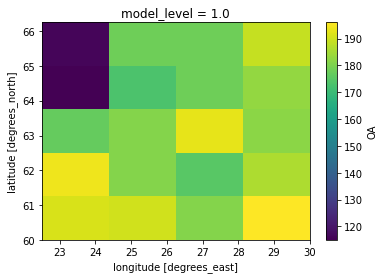

merge
df1


In [220]:
for seas in calc_seasons:
    _fn_csv = fn_final_ukesm_csv_stem.parent / (fn_final_ukesm_csv_stem.stem + seas + '.csv')
    print(_fn_csv)
    if True:  # not _fn_csv.exists():
        # for key in dic_ds.keys():

        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month[seas],
                                mask_cloud_values=True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds=dict(min_reff=r_eff_lim, min_cwp=cld_water_path_above,
                                                       tau_bounds=tau_lims),

                                )

        df_mod = dic_df[case_name_ukesm]
        # with ProgressBar():
        # df_mod = df_mod.dropna()
        df_mod.to_csv(_fn_csv)

In [221]:
dic_ds['AEROCOMTRAJ']['CWP'].quantile(.95)

<xarray.DataArray 'CWP' ()>
array(362.39912415)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [222]:
_ds

<xarray.Dataset>
Dimensions:       (lat: 5, model_level: 85, lon: 4, time: 20456)
Coordinates:
  * lat           (lat) float32 60.62 61.88 63.12 64.38 65.62
  * lon           (lon) float32 23.44 25.31 27.19 29.06
  * model_level   (model_level) float32 1.0 2.0 3.0 4.0 ... 82.0 83.0 84.0 85.0
  * time          (time) datetime64[ns] 2012-01-01 ... 2018-12-31T21:00:00
Data variables:
    level_height  (model_level) float32 ...
    rho           (time, model_level, lat, lon) float32 ...
    sigma         (model_level) float32 ...
Attributes:
    conventions:  CF-1.7
    source:       Met Office Unified Model
    version:      11.1
    model:        UKESM1.0
    realm:        atmosphere
    institution:  CEMPS, University of Exeter
    project:      AeroCom
    experiment:   GCMTraj
    history:      Mon Mar 20 19:37:37 2023: ncrcat -O /proj/bolinc/users/x_sa...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...